In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import sys
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

from skopt import gp_minimize
from skopt.space import Integer, Real

tf.keras.backend.set_floatx('float32')

plt.rcParams.update({
    "text.usetex":True,
    "font.family":"serif"
})

In [3]:
colab_flag = False
FTYPE = np.float32
ITYPE = np.int32

array = np.array
float32 = np.float32
int32 = np.int32
float64 = np.float64
int64 = np.int64

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/new_cdv


In [44]:
from tools.misc_tools import create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, return_hilbert_x0, plot_histogram_and_save
from tools.ae_v2 import Autoencoder
from tools.GRU_SingleStep_v1 import RNN_GRU
from tools.GRU_AR_v1 import AR_RNN_GRU
from tools.AEGRU_AR_v1 import AR_AERNN_GRU
from tools.hyper_param_GRU import trainGRU_and_return_PH

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpointAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
# setting seed for PRNGs
if behaviour == 'initialiseAndTrainFromScratch':
    prng_seed = 42
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [10]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 0
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

2023-07-11 10:44:43.760147: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-11 10:44:43.815237: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-11 10:44:43.815577: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2023-07-11 10:44:43.817748: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-11 10:44:43.818554: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-11 10:44:43.819349: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-11 10:44:43.819754: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so retur

In [11]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print(tf.config.list_logical_devices())
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]
2.8.1


# KS System

In [12]:
# setting up params (and saving, if applicable)
from numpy import *

# making RNN save directory
dir_name_rnn = os.getcwd() + dir_sep + 'GRU_params_Search'
dir_name_rnn += dir_sep + 'params_search_001'

with open(dir_name_rnn + '/optim_params.txt', 'r') as f:
    lines = f.readlines()
optimparams_dict = eval(''.join(lines))

vary_zoneout = optimparams_dict['vary_zoneout']
fRMS_bounds = optimparams_dict['fRMS_bounds']
lambda_reg_bounds = optimparams_dict['lambda_reg_bounds']
if vary_zoneout == True:
    zoneout_bounds = optimparams_dict['zoneout_bounds']

n_pregp = 20

In [13]:
# dname_single_rnn = dir_name_rnn + '/tested_rnn/test_rnn_000'

# with open(dname_single_rnn+'/final_net/final_net_class_dict.txt', 'r') as f:
#     lines = f.readlines()
# rnnfnc_dict = eval(''.join(lines))

# for key in rnnfnc_dict.keys():
#     print(key + ' = rnnfnc_dict["{}"]'.format(key))

data_dim = rnnfnc_dict["data_dim"]
dt_rnn = rnnfnc_dict["dt_rnn"]
lambda_reg = rnnfnc_dict["lambda_reg"]
reg_name = rnnfnc_dict["reg_name"]
rnn_layers_units = rnnfnc_dict["rnn_layers_units"]
dense_layer_act_func = rnnfnc_dict["dense_layer_act_func"]
load_file = rnnfnc_dict["load_file"]
mean = rnnfnc_dict["mean"]
stddev = rnnfnc_dict["stddev"]
noise_type = rnnfnc_dict["noise_type"]
module = rnnfnc_dict["module"]
dense_dim = rnnfnc_dict["dense_dim"]
use_learnable_state = rnnfnc_dict["use_learnable_state"]
stateful = rnnfnc_dict["stateful"]
scalar_weights = rnnfnc_dict["scalar_weights"]
use_weights_post_dense = rnnfnc_dict["use_weights_post_dense"]
zoneout_rate = rnnfnc_dict["zoneout_rate"]
rnncell_dropout_rate = rnnfnc_dict["rnncell_dropout_rate"]
denselayer_dropout_rate = rnnfnc_dict["denselayer_dropout_rate"]


In [14]:
dname_single_rnn = dir_name_rnn + '/tested_rnn/test_rnn_000'

with open(dname_single_rnn+'/sim_data_AE_params.txt', 'r') as f:
    lines = f.readlines()
simdataae_dict = eval(''.join(lines))

params_mat = simdataae_dict["params_mat"]
init_state_mat = simdataae_dict["init_state_mat"]
t0 = simdataae_dict["t0"]
T = simdataae_dict["T"]
delta_t = simdataae_dict["delta_t"]
return_params_arr = simdataae_dict["return_params_arr"]
dir_name_ae = simdataae_dict["dir_name_ae"]
normalize_dataset = simdataae_dict["normalize_dataset"]
stddev_multiplier = simdataae_dict["stddev_multiplier"]
use_ae_data = simdataae_dict["use_ae_data"]

with open(dname_single_rnn+'/training_specific_params.txt', 'r') as f:
    lines = f.readlines()
rnntrainspec_dict = eval(''.join(lines))

epochs = rnntrainspec_dict["epochs"]
prng_seed = rnntrainspec_dict["prng_seed"]
train_split = rnntrainspec_dict["train_split"]
val_split = rnntrainspec_dict["val_split"]
batch_size = rnntrainspec_dict["batch_size"]
timeMeanofSpaceRMS = rnntrainspec_dict["timeMeanofSpaceRMS"]
min_delta = rnntrainspec_dict["min_delta"]
patience = rnntrainspec_dict["patience"]
rnncell_dropout_rate = rnntrainspec_dict["rnncell_dropout_rate"]
denselayer_dropout_rate = rnntrainspec_dict["denselayer_dropout_rate"]
fRMS = rnntrainspec_dict["fRMS"]
lambda_reg = rnntrainspec_dict["lambda_reg"]
stddev = rnntrainspec_dict["stddev"]
zoneout_rate = rnntrainspec_dict["zoneout_rate"]

test_split = 1. - train_split - val_split

with open(dname_single_rnn+'/RNN_specific_data.txt', 'r') as f:
    lines = f.readlines()
rnnspec_dict = eval(''.join(lines))

dt_rnn = rnnspec_dict["dt_rnn"]
T_sample_input = rnnspec_dict["T_sample_input"]
T_sample_output = rnnspec_dict["T_sample_output"]
T_offset = rnnspec_dict["T_offset"]
boundary_idx_arr = rnnspec_dict["boundary_idx_arr"]
delta_t = rnnspec_dict["delta_t"]
params = rnnspec_dict["params"]
return_params_arr = rnnspec_dict["return_params_arr"]
normalize_dataset = rnnspec_dict["normalize_dataset"]
num_lyaptimesteps_totrain = rnnspec_dict["num_lyaptimesteps_totrain"]
stddev_multiplier = rnnspec_dict["stddev_multiplier"]
skip_intermediate = rnnspec_dict["skip_intermediate"]
module = rnnspec_dict["module"]
noise_type = rnnspec_dict["noise_type"]
normalization_type = rnnspec_dict["normalization_type"]
dense_layer_act_func = rnnspec_dict["dense_layer_act_func"]
stateful = rnnspec_dict["stateful"]
use_learnable_state = rnnspec_dict["use_learnable_state"]
use_weights_post_dense = rnnspec_dict["use_weights_post_dense"]
use_trainable_weights_with_reslayers = rnnspec_dict["use_trainable_weights_with_reslayers"]


with open(dname_single_rnn+'/final_net/final_net_class_dict.txt', 'r') as f:
    lines = f.readlines()
rnnfnc_dict = eval(''.join(lines))

reg_name = rnnfnc_dict["reg_name"]
rnn_layers_units = rnnfnc_dict["rnn_layers_units"]
dense_layer_act_func = rnnfnc_dict["dense_layer_act_func"]
mean = rnnfnc_dict["mean"]
noise_type = rnnfnc_dict["noise_type"]
dense_dim = rnnfnc_dict["dense_dim"]
use_learnable_state = rnnfnc_dict["use_learnable_state"]
stateful = rnnfnc_dict["stateful"]
scalar_weights = rnnfnc_dict["scalar_weights"]
use_weights_post_dense = rnnfnc_dict["use_weights_post_dense"]
zoneout_rate = rnnfnc_dict["zoneout_rate"]
if vary_zoneout == False:
    zoneout_x0 = zoneout_rate
rnncell_dropout_rate = rnnfnc_dict["rnncell_dropout_rate"]
denselayer_dropout_rate = rnnfnc_dict["denselayer_dropout_rate"]

In [15]:
# reading simulation parameters
with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
data_dir_idx = params_dict['data_dir_idx']
normalizeforae_flag = params_dict['normalizeforae_flag']
normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']
try:
    ae_data_with_params = params_dict['ae_data_with_params']
except:
    print("'ae_data_with_params' not present in ae_data, set to 'True'.")
    ae_data_with_params = True

if os.path.exists(dir_name_ae+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]

print('dir_name_rnn:', dir_name_rnn)
print('use_ae_data : ' + str(use_ae_data) + ', dir_name_ae:', dir_name_ae)
print('data_dir_idx:', data_dir_idx)

# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state = params_dict['init_state']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

with np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True) as fl:
    all_data = fl['all_data'].astype(FTYPE)
    boundary_idx_arr = fl['boundary_idx_arr']
    normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
    initial_t0 = fl['initial_t0']
    init_state_mat = fl['init_state_mat']

    lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']

dir_name_rnn: /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001
use_ae_data : True, dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae/ae_008
data_dir_idx: 004
normalize_flag_ogdata: False


In [16]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.027086916024239262, lyapunov time : 36.91819381713867s


In [17]:
positve_lp_idx = np.where(lyapunov_time_arr > 0)[0]
print(positve_lp_idx)

[0]


In [18]:
last_idx = all_data.shape[0]
temp_bia = np.zeros(shape=1+boundary_idx_arr.shape[0], dtype=np.int32)
temp_bia[1:] = boundary_idx_arr
print(temp_bia)
for i in range(boundary_idx_arr.shape[0]-1, -1, -1):
    if not (i in positve_lp_idx):
        print(i)
        num_idxs = last_idx - temp_bia[i+1]
        all_data[temp_bia[i]:temp_bia[i]+num_idxs] = all_data[temp_bia[i+1]:last_idx]
        last_idx = last_idx - (temp_bia[i+1]-temp_bia[i])

[     0 500001]


In [19]:
new_bia = np.empty_like(boundary_idx_arr)
new_bia[:] = boundary_idx_arr
new_pmat = np.empty_like(params_mat)
new_pmat[:, :] = params_mat
counter = 0
bia_counter = boundary_idx_arr.shape[0]
for i in range(boundary_idx_arr.shape[0]):
    if not (i in positve_lp_idx):
        new_bia[i:] -= temp_bia[i+1] - temp_bia[i]
        new_bia[i:bia_counter-1] = new_bia[i+1:bia_counter]
        new_pmat[i:bia_counter-1] = new_pmat[i+1:bia_counter]
        bia_counter -= 1

In [20]:
new_bia = new_bia[0:bia_counter]
new_pmat = new_pmat[0:bia_counter]

In [21]:
all_data = all_data[0:new_bia[-1]]

In [22]:
new_bia, boundary_idx_arr = boundary_idx_arr, new_bia
new_pmat, params_mat = params_mat, new_pmat

In [23]:
# delaing with normalizing the data before feeding into autoencoder
num_params = params_mat.shape[1]
og_vars = all_data.shape[1]
if alldata_withparams_flag == True:
    og_vars -= num_params

time_stddev_ogdata = np.std(all_data[:, 0:og_vars], axis=0)
time_mean_ogdata = np.mean(all_data[:, 0:og_vars], axis=0)
    
if use_ae_data == True:
    if ae_data_with_params == True and alldata_withparams_flag == False:
        new_all_data = np.empty(shape=(all_data.shape[0], og_vars+num_params), dtype=FTYPE)
        new_all_data[:, 0:og_vars] = all_data[:, 0:og_vars]
        del(all_data)
        all_data = new_all_data
        prev_idx = 0
        for i in range(boundary_idx_arr.shape[0]):
            all_data[prev_idx:boundary_idx_arr[i], num_params:] = params_mat[i]
            prev_idx = boundary_idx_arr[i]

    if normalizeforae_flag == True:
        for i in range(all_data.shape[1]):
            all_data[:, i] -= normalization_constant_arr_aedata[0, i]
            all_data[:, i] /= normalization_constant_arr_aedata[1, i]

    if ae_data_with_params == False:
        all_data = all_data[:, 0:og_vars]
else:
    # using raw data, neglecting the params attached (if any)
    all_data = all_data[:, 0:og_vars]

# Autoencoder

In [24]:
if use_ae_data == True:
    load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
    wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

In [25]:
if use_ae_data == True:
    ae_net = Autoencoder(all_data.shape[1], load_file=load_file)
    ae_net.load_weights_from_file(wt_file)

In [26]:
# create data
if use_ae_data == True:
    latent_states_all = ae_net.encoder_net.predict(all_data)
    # del(all_data)
else:
    latent_states_all = all_data
num_latent_states = latent_states_all.shape[1]

# GRU

In [27]:
# latent_states_all = latent_states_all[0:375009]
# boundary_idx_arr = [375009]

In [29]:
normalization_arr = None
rnn_res_dict = create_data_for_RNN(
    latent_states_all,
    dt_rnn,
    T_sample_input,
    T_sample_output,
    T_offset,
    None,
    boundary_idx_arr,
    delta_t,
    params=params,
    return_numsamples=True,
    normalize_dataset=normalize_dataset,
    stddev_multiplier=stddev_multiplier,
    skip_intermediate=skip_intermediate,
    return_OrgDataIdxArr=False,
    normalization_arr_external=normalization_arr,
    normalization_type=normalization_type,
    FTYPE=FTYPE,
    ITYPE=ITYPE)
    
data_rnn_input = rnn_res_dict['data_rnn_input']
data_rnn_output = rnn_res_dict['data_rnn_output']
org_data_idx_arr_input = rnn_res_dict['org_data_idx_arr_input']
org_data_idx_arr_output = rnn_res_dict['org_data_idx_arr_output']
num_samples = rnn_res_dict['num_samples']
normalization_arr = rnn_res_dict['normalization_arr']
rnn_data_boundary_idx_arr = rnn_res_dict['rnn_data_boundary_idx_arr']

In [30]:
temp = np.divide(latent_states_all-normalization_arr[0], normalization_arr[1])
time_stddev = np.std(temp, axis=0)
timeMeanofSpaceRMS = np.mean(np.mean(temp**2, axis=1)**0.5)
del(org_data_idx_arr_input)
del(org_data_idx_arr_output)
del(latent_states_all)
del(temp)

In [31]:
rnn_res_dict = create_data_for_RNN(
    all_data,
    dt_rnn,
    T_sample_input,
    T_sample_output,
    T_offset,
    None,
    boundary_idx_arr,
    delta_t,
    params=params,
    return_numsamples=True,
    normalize_dataset=False,
    stddev_multiplier=stddev_multiplier,
    skip_intermediate=skip_intermediate,
    return_OrgDataIdxArr=False,
    normalization_arr_external=normalization_arr,
    normalization_type=normalization_type,
    FTYPE=FTYPE,
    ITYPE=ITYPE)
    
AR_data_rnn_input = rnn_res_dict['data_rnn_input']
AR_data_rnn_output = rnn_res_dict['data_rnn_output']
AR_org_data_idx_arr_input = rnn_res_dict['org_data_idx_arr_input']
AR_org_data_idx_arr_output = rnn_res_dict['org_data_idx_arr_output']
AR_num_samples = rnn_res_dict['num_samples']
AR_normalization_arr = rnn_res_dict['normalization_arr']
AR_rnn_data_boundary_idx_arr = rnn_res_dict['rnn_data_boundary_idx_arr']

del(AR_org_data_idx_arr_input)
del(AR_org_data_idx_arr_output)
del(AR_rnn_data_boundary_idx_arr)

In [32]:
# setting up training params
learning_rate_list = [1e-2, 1e-3, 1e-4]#, 1e-5]
epochs = 150
patience = 10 # parameter for early stopping
min_delta = 1e-6  # parameter for early stopping
train_split = 0.8
val_split = 0.1
test_split = 1 - train_split - val_split
batch_size = 32
rnncell_dropout_rate = 0.0
denselayer_dropout_rate = 0.0

lambda_reg_x0 = 1e-7 # weight for regularizer
fRMS_x0 = 1e-3

rnncell_dropout_rate = 0.0
denselayer_dropout_rate = 0.0

# ph computation parameters
num_runs = 50
T_sample_input_AR_ratio = 1
T_sample_output_AR_ratio = 3

# saving training params
training_specific_params = {
    'epochs':epochs,
    'prng_seed':prng_seed,
    'train_split':train_split,
    'val_split':val_split,
    'batch_size':batch_size,
    # 'fRMS':fRMS,
    'timeMeanofSpaceRMS':timeMeanofSpaceRMS,
    # 'stddev':stddev,
    # 'lambda_reg':lambda_reg,
    'min_delta':min_delta,
    'patience':patience,
    'rnncell_dropout_rate':rnncell_dropout_rate,
    'denselayer_dropout_rate':denselayer_dropout_rate,
    'learning_rate_list':learning_rate_list,
}

In [73]:
# saving simulation data
sim_data = {
    'params_mat':params_mat,
    'init_state_mat':init_state_mat,
    't0':t0,
    'T':T,
    'delta_t':delta_t,
    'return_params_arr':return_params_arr,
    'dir_name_ae':dir_name_ae,
    'normalize_dataset':normalize_dataset,
    'stddev_multiplier':stddev_multiplier,
    'use_ae_data':use_ae_data,
}

# saving RNN specific data
RNN_specific_data = {    
    'dt_rnn':dt_rnn,
    'T_sample_input':T_sample_input,
    'T_sample_output':T_sample_output,
    'T_offset':T_offset,
    'boundary_idx_arr':boundary_idx_arr,
    'delta_t':delta_t,
    'params':params,
    'return_params_arr':return_params_arr,
    'normalize_dataset':normalize_dataset,
    'num_lyaptimesteps_totrain':num_lyaptimesteps_totrain,
    'stddev_multiplier':stddev_multiplier,
    'skip_intermediate':skip_intermediate,
    'module':RNN_GRU.__module__,
    'noise_type':noise_type,
    'normalization_type':normalization_type,
    'dense_layer_act_func':dense_layer_act_func,
    'stateful':stateful,
    'use_learnable_state':use_learnable_state,
    'use_weights_post_dense':use_weights_post_dense,
    'use_trainable_weights_with_reslayers':use_trainable_weights_with_reslayers,
}

In [33]:
cum_samples = rnn_data_boundary_idx_arr[-1]
# idx = np.arange(cum_samples)
# np.random.shuffle(idx)
num_train_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
num_val_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
num_test_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
num_samples_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
begin_idx = 0
for i in range(len(rnn_data_boundary_idx_arr)):
    num_samples = batch_size * int((rnn_data_boundary_idx_arr[i] - begin_idx) // batch_size)
    num_train_arr[i] = batch_size * int( np.round(train_split*num_samples/batch_size) )
    num_val_arr[i] = batch_size * int( np.round(val_split*num_samples/batch_size) )
    num_test_arr[i] = batch_size * int( np.round((num_samples - num_train_arr[i] - num_val_arr[i])/batch_size) )
    num_samples_arr[i] = num_train_arr[i] + num_val_arr[i] + num_test_arr[i]
    begin_idx = rnn_data_boundary_idx_arr[i]

# defining shapes
training_input_shape = [np.sum(num_train_arr)]
training_input_shape.extend(data_rnn_input.shape[1:])

training_output_shape = [np.sum(num_train_arr)]
training_output_shape.extend(data_rnn_output.shape[1:])

val_input_shape = [np.sum(num_val_arr)]
val_input_shape.extend(data_rnn_input.shape[1:])

val_output_shape = [np.sum(num_val_arr)]
val_output_shape.extend(data_rnn_output.shape[1:])

testing_input_shape = [np.sum(num_test_arr)]
testing_input_shape.extend(data_rnn_input.shape[1:])

testing_output_shape = [np.sum(num_test_arr)]
testing_output_shape.extend(data_rnn_output.shape[1:])

# defining required arrays
training_data_rnn_input = np.empty(shape=training_input_shape, dtype=FTYPE)
training_data_rnn_output = np.empty(shape=training_output_shape, dtype=FTYPE)

val_data_rnn_input = np.empty(shape=val_input_shape, dtype=FTYPE)
val_data_rnn_output = np.empty(shape=val_output_shape, dtype=FTYPE)

testing_data_rnn_input = np.empty(shape=testing_input_shape, dtype=FTYPE)
testing_data_rnn_output = np.empty(shape=testing_output_shape, dtype=FTYPE)

AR_testing_data_rnn_input = np.empty(shape=tuple(testing_input_shape[0:2])+tuple(AR_data_rnn_input.shape[2:]), dtype=FTYPE)
AR_testing_data_rnn_output = np.empty(shape=tuple(testing_input_shape[0:2])+tuple(AR_data_rnn_input.shape[2:]), dtype=FTYPE)

begin_idx = 0
training_data_rolling_count = 0
val_data_rolling_count = 0
testing_data_rolling_count = 0
for i in range(len(boundary_idx_arr)):
    idx = np.arange(begin_idx, rnn_data_boundary_idx_arr[i])
    # np.random.shuffle(idx)
    # num_samples = idx.shape[0]
    # num_train = int( np.round(train_split*num_samples/batch_size) )*batch_size
    # num_val = int( np.round(val_split*num_samples/batch_size) )*batch_size
    
    num_samples = num_samples_arr[i]
    num_train = num_train_arr[i]
    num_val = num_val_arr[i]
    num_test = num_test_arr[i]
    
    nbatches_train = num_train // batch_size
    nbatches_val = num_val // batch_size
    nbatches_test = num_test // batch_size

    for j in range(batch_size):
        training_data_rnn_input[training_data_rolling_count+j:training_data_rolling_count+num_train:batch_size] = data_rnn_input[idx[0:num_train]][j*nbatches_train:(j+1)*nbatches_train]
        training_data_rnn_output[training_data_rolling_count+j:training_data_rolling_count+num_train:batch_size] = data_rnn_output[idx[0:num_train]][j*nbatches_train:(j+1)*nbatches_train]
        
        val_data_rnn_input[val_data_rolling_count+j:val_data_rolling_count+num_val:batch_size] = data_rnn_input[idx[num_train:num_train+num_val]][j*nbatches_val:(j+1)*nbatches_val]
        val_data_rnn_output[val_data_rolling_count+j:val_data_rolling_count+num_val:batch_size] = data_rnn_output[idx[num_train:num_train+num_val]][j*nbatches_val:(j+1)*nbatches_val]

        testing_data_rnn_input[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size] = data_rnn_input[idx[num_train+num_val:num_samples]][j*nbatches_test:(j+1)*nbatches_test]
        testing_data_rnn_output[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size] = data_rnn_output[idx[num_train+num_val:num_samples]][j*nbatches_test:(j+1)*nbatches_test]

    AR_testing_data_rnn_input[testing_data_rolling_count:testing_data_rolling_count+num_test] = AR_data_rnn_input[idx[num_train+num_val:num_samples]]
    AR_testing_data_rnn_output[testing_data_rolling_count:testing_data_rolling_count+num_test] = AR_data_rnn_output[idx[num_train+num_val:num_samples]]

    # training_data_rnn_input[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_input[idx[0:num_train]]
    # training_data_rnn_output[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_output[idx[0:num_train]]
    training_data_rolling_count += num_train

    # val_data_rnn_input[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_input[idx[num_train:num_train+num_val]]
    # val_data_rnn_output[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_output[idx[num_train:num_train+num_val]]
    val_data_rolling_count += num_val

    # num_test = num_samples-num_train-num_val+1
    # testing_data_rnn_input[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_input[idx[num_train+num_val:]]
    # testing_data_rnn_output[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_output[idx[num_train+num_val:]]
    testing_data_rolling_count += num_test

    begin_idx = rnn_data_boundary_idx_arr[i]

# cleaning up
del(data_rnn_input)
del(data_rnn_output)
del(AR_data_rnn_input)
del(AR_data_rnn_output)

# further shuffling
if stateful == False:
    idx = np.arange(0, training_data_rnn_input.shape[0])
    np.random.shuffle(idx)
    training_data_rnn_input = training_data_rnn_input[idx]
    training_data_rnn_output = training_data_rnn_output[idx]

    idx = np.arange(0, val_data_rnn_input.shape[0])
    np.random.shuffle(idx)
    val_data_rnn_input = val_data_rnn_input[idx]
    val_data_rnn_output = val_data_rnn_output[idx]

    idx = np.arange(0, testing_data_rnn_input.shape[0])
    np.random.shuffle(idx)
    testing_data_rnn_input = testing_data_rnn_input[idx]
    testing_data_rnn_output = testing_data_rnn_output[idx]

    del(idx)

In [34]:
s_in = AR_testing_data_rnn_input.shape
AR_testing_data_rnn_input = AR_testing_data_rnn_input.reshape((1, s_in[0]*s_in[1]) + s_in[2:])

s_out = AR_testing_data_rnn_output.shape
AR_testing_data_rnn_output = AR_testing_data_rnn_output.reshape((1, s_out[0]*s_out[1]) + s_out[2:])

T_sample_input_AR = T_sample_input_AR_ratio*np.mean(lyapunov_time_arr)#50.1*dt_rnn
num_sample_input_AR = int((T_sample_input_AR+0.5*dt_rnn)//dt_rnn)

T_sample_output_AR = T_sample_output_AR_ratio*np.mean(lyapunov_time_arr)
num_sample_output_AR = int((T_sample_output_AR+0.5*dt_rnn)//dt_rnn)

num_offset_AR = num_sample_input_AR
T_offset_AR = num_offset_AR*dt_rnn

batch_idx = np.random.randint(low=0, high=AR_testing_data_rnn_input.shape[0])
maxpossible_num_runs = AR_testing_data_rnn_input.shape[1]-(num_sample_input_AR+num_sample_output_AR)

num_runs = np.min([num_runs, maxpossible_num_runs])

print('num_runs : ', num_runs)

data_idx_arr = np.linspace(0, maxpossible_num_runs-1, num_runs, dtype=np.int32)

num_runs :  50


In [35]:
AR_data_in = np.empty(shape=(num_runs, num_sample_input_AR)+tuple(s_in[2:]))
AR_data_out = np.empty(shape=(num_runs, num_sample_output_AR)+tuple(s_out[2:]))

for i in range(num_runs):
    d_idx = data_idx_arr[i]
    AR_data_in[i] = AR_testing_data_rnn_input[0, d_idx:d_idx+num_sample_input_AR]
    AR_data_out[i] = AR_testing_data_rnn_input[0, d_idx+num_sample_input_AR:d_idx+num_sample_input_AR+num_sample_output_AR]

In [36]:
del(AR_testing_data_rnn_input)
del(AR_testing_data_rnn_output)
AR_testing_data_rnn_input = AR_data_in
AR_testing_data_rnn_output = AR_data_out

In [37]:
print('   training_data_rnn_input.shape : ', training_data_rnn_input.shape)
print('  training_data_rnn_output.shape : ', training_data_rnn_output.shape)
print('    testing_data_rnn_input.shape : ', testing_data_rnn_input.shape)
print('   testing_data_rnn_output.shape : ', testing_data_rnn_output.shape)
print('        val_data_rnn_input.shape : ', val_data_rnn_input.shape)
print('       val_data_rnn_output.shape : ', val_data_rnn_output.shape)
print('')
print(' AR_testing_data_rnn_input.shape : ', AR_testing_data_rnn_input.shape)
print('AR_testing_data_rnn_output.shape : ', AR_testing_data_rnn_output.shape)

   training_data_rnn_input.shape :  (352, 554, 5)
  training_data_rnn_output.shape :  (352, 554, 5)
    testing_data_rnn_input.shape :  (64, 554, 5)
   testing_data_rnn_output.shape :  (64, 554, 5)
        val_data_rnn_input.shape :  (32, 554, 5)
       val_data_rnn_output.shape :  (32, 554, 5)

 AR_testing_data_rnn_input.shape :  (50, 185, 6)
AR_testing_data_rnn_output.shape :  (50, 554, 6)


In [38]:
testrnn_dirlist = []
testrnn_dirlist_idx = []
for dname in os.listdir(dir_name_rnn+'/tested_rnn'):
    if os.path.isdir(os.path.join(dir_name_rnn+'/tested_rnn', dname)):
        testrnn_dirlist.append(os.path.join(dir_name_rnn+'/tested_rnn', dname))
        rnnidx = int(testrnn_dirlist[-1][-3:])
        testrnn_dirlist_idx.append(rnnidx)

sorted_idx = np.argsort(testrnn_dirlist_idx)
testrnn_dirlist_idx = np.array(testrnn_dirlist_idx)[sorted_idx]
testrnn_dirlist = np.array(testrnn_dirlist)[sorted_idx]

In [39]:
def invert_normalization(data, normalization_arr):
    new_data = np.empty_like(data)
    new_data[:] = data[:]
    new_data *= normalization_arr[1]
    new_data += normalization_arr[0]
    return new_data

In [47]:
x0 = []
ph_mean = []
ph_median = []
ae_data_normalization_arr = normalization_constant_arr_aedata
error_threshold = 0.5

for dname in testrnn_dirlist:
    analysis_time = time.time()

    with open(dname+'/training_specific_params.txt', 'r') as f:
        lines = f.readlines()
    rnntrainspec_dict = eval(''.join(lines))

    lambda_reg_i = rnntrainspec_dict["lambda_reg"]
    fRMS_i = rnntrainspec_dict["fRMS"]
    zoneout_rate_i = rnntrainspec_dict["zoneout_rate"]
    
    x0_i = [fRMS_i, lambda_reg_i]
    if vary_zoneout == True:
        x0_i.append(zoneout_rate_i)
    x0.append(x0_i)

    rnn_load_file = dname + '/final_net/final_net_class_dict.txt'
    rnn_wt_file = dname + '/final_net/final_net_gru_weights.h5'
    
    num_runs = AR_testing_data_rnn_input.shape[0]
    
    AR_rnn_net = AR_RNN_GRU(
        load_file=rnn_load_file,
        T_input=T_sample_input_AR,
        T_output=T_sample_output_AR,
        stddev=0.0,
        batch_size=num_runs,
        lambda_reg=lambda_reg_i,
    )
    AR_rnn_net.build(input_shape=tuple(AR_testing_data_rnn_input.shape[0:2]) + tuple(testing_data_rnn_input.shape[2:]))
    AR_rnn_net.load_weights_from_file(rnn_wt_file)

    AR_AERNN_net = AR_AERNN_GRU(
        ae_net,
        AR_rnn_net,
        normalization_arr,
        normalization_constant_arr_aedata,
        covmat_lmda=0.0,
        time_stddev_ogdata=time_stddev_ogdata,
        time_mean_ogdata=time_mean_ogdata,
        loss_weights=None,
        clipnorm=None,
        global_clipnorm=None
    )

    savefig_fname = 'pre_ARtraining-testingdata--combinedAERNN--ZEROoutsteps'
    npsavedata_fname = '/prediction_horizons-testingdata--combinedAERNN--ZEROoutsteps'
    plot_dir = '/plots'

    sidx1 = dname[::-1].index('/')
    sidx2 = dname[-sidx1-2::-1].index('/')
    print(dname[-(sidx1+sidx2+1):])
    print('num_runs :', num_runs)

    prediction_horizon_arr = np.empty(shape=num_runs)
    prediction = np.array(AR_AERNN_net(AR_testing_data_rnn_input, training=False))
    prediction = invert_normalization(prediction, ae_data_normalization_arr)
    if len(prediction.shape) == 4:
        print(prediction.shape)
        prediction = prediction[0]

    data_in_og = AR_testing_data_rnn_input
    data_out_og = AR_testing_data_rnn_output

    energySpectrum_dataout = 0.0
    energySpectrum_pred = 0.0

    avg_time = 0.
    for i in range(num_runs):
        run_time = time.time()
        lyap_time = lyapunov_time_arr[0]

        data_out = data_out_og[i]
        data_out = invert_normalization(data_out, ae_data_normalization_arr)

        ### Error and prediction horizon
        error = (data_out - prediction[i])**2
        error = np.mean(np.divide(error, time_stddev_ogdata**2), axis=1)**0.5

        predhor_idx = np.where(error >= error_threshold)[0]
        if predhor_idx.shape[0] == 0:
            predhor_idx = error.shape[0]
        else:
            predhor_idx = predhor_idx[0]

        prediction_horizon_arr[i] = predhor_idx*dt_rnn/lyap_time
        
        run_time = time.time() - run_time
        avg_time = (avg_time*i + run_time)/(i+1)
        eta = avg_time * (num_runs-1 - i)
        # print('    {} / {} -- run_time : {:.2f} s -- eta : {:.0f}h {:.0f}m {:.0f}s'.format(
        #     i+1,
        #     num_runs,
        #     run_time,
        #     float(eta // 3600),
        #     float((eta%3600)//60),
        #     float((eta%3600)%60),
        # ))

    median_idx = int(np.round(0.5*num_runs-1))
    quartile_1_idx = int(np.round(0.25*num_runs-1))
    quartile_3_idx = int(np.round(0.75*num_runs-1))

    prediction_horizon_arr.sort()

    median = prediction_horizon_arr[median_idx]
    quartile_1 = prediction_horizon_arr[quartile_1_idx]
    quartile_3 = prediction_horizon_arr[quartile_3_idx]
    IQR = quartile_3 - quartile_1

    prediction_horizon = np.mean(prediction_horizon_arr)
    stddev_ph = np.std(prediction_horizon_arr)

    analysis_time = time.time() - analysis_time
    s = 'error_threshold = {}, num_runs : {}\n'.format(error_threshold, num_runs)
    s += 'prediction_horizon : {}, median : {}\n'.format(prediction_horizon, median)
    s += 'ph_min : {}, ph_max : {}\n'.format(prediction_horizon_arr.min(), prediction_horizon_arr.max())
    s += 'stddev : {}, IQR : {}\n'.format(stddev_ph, IQR)
    s += '1st quartile : {}, 3rd quartile : {}\n\n'.format(quartile_1, quartile_3)

    print('    analysis_time : {:.0f} sec.\n'.format(analysis_time)+s)
    
    ph_mean.append(prediction_horizon)
    ph_median.append(median)
    
    plot_histogram_and_save(
        prediction_horizon_arr, median,
        save_dir=dname+'/plots',
        savefig_fname=savefig_fname,
    )

    np.savez(
        dname+npsavedata_fname,
        prediction_horizon_arr=prediction_horizon_arr,
        error_threshold=error_threshold,
    )

    with open(dname+npsavedata_fname+'--statistics.txt', 'w') as fl:
        fl.write(s)

tested_rnn/test_rnn_000
num_runs : 50
    analysis_time : 156 sec.
error_threshold = 0.5, num_runs : 50
prediction_horizon : 0.7699184889918591, median : 0.7259293380587469
ph_min : 0.15168672735555908, ph_max : 2.1019446504984614
stddev : 0.40902159553215406, IQR : 0.4008863508682633
1st quartile : 0.4983992470254084, 3rd quartile : 0.8992855978936717


tested_rnn/test_rnn_001
num_runs : 50
    analysis_time : 156 sec.
error_threshold = 0.5, num_runs : 50
prediction_horizon : 0.7668847544447478, median : 0.7313467211785883
ph_min : 0.15168672735555908, ph_max : 2.123614182977827
stddev : 0.4119365585388941, IQR : 0.3954689677484218
1st quartile : 0.4983992470254084, 3rd quartile : 0.8938682147738302


tested_rnn/test_rnn_002
num_runs : 50
    analysis_time : 156 sec.
error_threshold = 0.5, num_runs : 50
prediction_horizon : 0.7550748592434937, median : 0.7259293380587469
ph_min : 0.1571041104754005, ph_max : 1.8364928776262328
stddev : 0.37670394353845205, IQR : 0.42255588334762895
1s

    analysis_time : 157 sec.
error_threshold = 0.5, num_runs : 50
prediction_horizon : 0.8895343082779571, median : 0.6338338250214433
ph_min : 0.23294747415317998, ph_max : 3.001230248392133
stddev : 0.7464611394846733, IQR : 0.49298186390556686
1st quartile : 0.42797326646747025, 3rd quartile : 0.9209551303730371


tested_rnn/test_rnn_024
num_runs : 50
    analysis_time : 157 sec.
error_threshold = 0.5, num_runs : 50
prediction_horizon : 0.7887709822489072, median : 0.7367641042984298
ph_min : 0.15168672735555908, ph_max : 2.0369360530603644
stddev : 0.4466276739452876, IQR : 0.4008863508682634
1st quartile : 0.5146513963849325, 3rd quartile : 0.9155377472531959


tested_rnn/test_rnn_025
num_runs : 50
    analysis_time : 156 sec.
error_threshold = 0.5, num_runs : 50
prediction_horizon : 0.8960351680217667, median : 0.6609207406206502
ph_min : 0.2166953247936558, ph_max : 3.001230248392133
stddev : 0.7478602724579586, IQR : 0.5417383119841396
1st quartile : 0.4550601820666772, 3rd qua

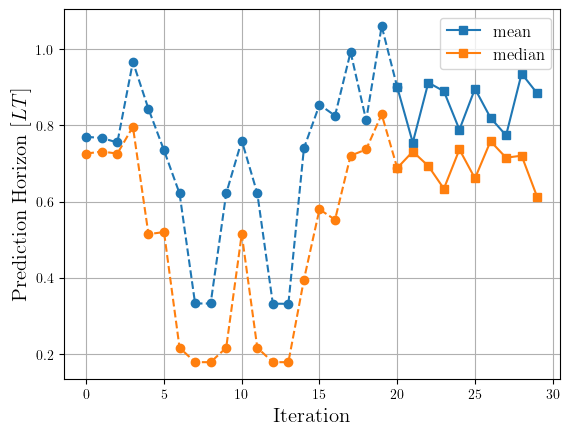

In [61]:
ph_mean = np.array(ph_mean)
ph_median = np.array(ph_median)

plt.plot(np.arange(0, n_pregp+1), ph_mean[0:n_pregp+1], color='C0', linestyle='--', marker='o', label='__nolegend__')
plt.plot(np.arange(n_pregp, ph_mean.shape[0]), ph_mean[n_pregp:], color='C0', linestyle='-', marker='s', label='mean')

plt.plot(np.arange(0, n_pregp+1), ph_median[0:n_pregp+1], color='C1', linestyle='--', marker='o', label='__nolegend__')
plt.plot(np.arange(n_pregp, ph_median.shape[0]), ph_median[n_pregp:], color='C1', linestyle='-', marker='s', label='median')

plt.xlabel('Iteration', fontsize=15)
plt.ylabel('Prediction Horizon $[ LT ]$', fontsize=15)
plt.grid(True)

plt.legend(fontsize=12)

# plt.show()
plt.savefig(dir_name_rnn+'/plots/CORRECTED_PH.pdf', dpi=300, bbox_inches='tight')

In [63]:
np.savez(
    dir_name_rnn+'/corrected_ph',
    ph_median=ph_median,
    ph_mean=ph_mean,
    num_runs=num_runs,
    error_threshold=error_threshold,
)

write_dict = {
    'ph_median':ph_median,
    'ph_mean':ph_mean,
    'num_runs':num_runs,
    'error_threshold':error_threshold,
}
with open(dir_name_rnn+'/corrected_ph.txt', 'w') as f:
    f.write(str(write_dict))

In [ ]:
training_data_rnn_input.dtype

In [74]:
def optim_func(
        x, # [fRMS, lambda_reg, zoneout]
        time_stddev=time_stddev,
        og_vars=og_vars,
        RNN_GRU=RNN_GRU,
        AR_RNN_GRU=AR_RNN_GRU,
        AR_AERNN_GRU=AR_AERNN_GRU,
        ae_net=ae_net,
        mytimecallback=mytimecallback,
        SaveLosses=SaveLosses,
        plot_losses=plot_losses,
        dir_name_rnn=dir_name_rnn,
        boundary_idx_arr=rnn_data_boundary_idx_arr,
        lyapunov_time_arr=lyapunov_time_arr,
        sim_data_dict=sim_data,
        RNN_specific_data_dict=RNN_specific_data,
        training_specific_params_dict=training_specific_params,
        normalization_arr=normalization_arr,
        training_data_rnn_input=training_data_rnn_input,
        training_data_rnn_output=training_data_rnn_output,
        testing_data_rnn_input=testing_data_rnn_input,
        testing_data_rnn_output=testing_data_rnn_output,
        val_data_rnn_input=val_data_rnn_input,
        val_data_rnn_output=val_data_rnn_output,
        AR_testing_data_rnn_input=AR_testing_data_rnn_input,
        AR_testing_data_rnn_output=AR_testing_data_rnn_output,
        return_params_arr=return_params_arr,
        normalize_dataset=normalize_dataset,
        dt_rnn=dt_rnn,
        noise_type=noise_type,
        ae_data_normalization_arr=normalization_constant_arr_aedata,
        time_stddev_ogdata=time_stddev_ogdata,
        time_mean_ogdata=time_mean_ogdata,
        T_sample_input=T_sample_input_AR,
        T_sample_output=T_sample_output_AR,
        rnn_layers_units=rnn_layers_units,
        stateful=stateful,
        reg_name='L2',
        dense_layer_act_func=dense_layer_act_func,
        use_learnable_state=use_learnable_state,
        use_weights_post_dense=use_weights_post_dense,
        rnncell_dropout_rate=rnncell_dropout_rate,
        denselayer_dropout_rate=denselayer_dropout_rate,
        scalar_weights=scalar_weights,
        prng_seed=prng_seed,
        epochs=epochs,
        learning_rate_list=learning_rate_list,
        patience=patience,  # parameter for early stopping
        min_delta=min_delta,  # parameter for early stopping
        batch_size=batch_size,
        zoneout=zoneout_x0,
    ):
    
    compute_time = time.time()
    
    x = [elem for elem in np.array(x).flatten()]
    if len(x) < 3:
        x.append(zoneout)

    median_PH = trainGRU_and_return_PH(
        x, # [fRMS, lambda_reg, zoneout]
        time_stddev,
        og_vars,
        RNN_GRU,
        AR_RNN_GRU,
        AR_AERNN_GRU,
        ae_net,
        mytimecallback,
        SaveLosses,
        plot_losses,
        dir_name_rnn,
        boundary_idx_arr,
        lyapunov_time_arr,
        sim_data_dict,
        RNN_specific_data_dict,
        training_specific_params_dict,
        normalization_arr,
        training_data_rnn_input,
        training_data_rnn_output,
        testing_data_rnn_input,
        testing_data_rnn_output,
        val_data_rnn_input,
        val_data_rnn_output,
        AR_testing_data_rnn_input,
        AR_testing_data_rnn_output,
        return_params_arr,
        normalize_dataset,
        dt_rnn,
        noise_type,
        ae_data_normalization_arr,
        time_stddev_ogdata,
        time_mean_ogdata,
        T_sample_input=T_sample_input,
        T_sample_output=T_sample_output,
        rnn_layers_units=rnn_layers_units,
        stateful=stateful,
        reg_name=reg_name,
        dense_layer_act_func=dense_layer_act_func,
        use_learnable_state=use_learnable_state,
        use_weights_post_dense=use_weights_post_dense,
        rnncell_dropout_rate=rnncell_dropout_rate,
        denselayer_dropout_rate=denselayer_dropout_rate,
        scalar_weights=scalar_weights,
        prng_seed=prng_seed,
        epochs=epochs,
        learning_rate_list=learning_rate_list,
        patience=patience,  # parameter for early stopping
        min_delta=min_delta,  # parameter for early stopping
        batch_size=batch_size,
        error_threshold=0.5,
        xlabel_kwargs={'fontsize':15},
        ylabel_kwargs={'fontsize':15},
        legend_kwargs={'fontsize':12},
    )
    
    compute_time = time.time() - compute_time
    print('compute_time : {:.0f}h {:.0f}m {:.0f}s'.format(
        float(compute_time // 3600),
        float((compute_time%3600)//60),
        float((compute_time%3600)%60),
    ))
    
    return -median_PH

In [68]:
x_bounds = [
    fRMS_bounds, # fRMS
    lambda_reg_bounds, # lambda_reg
]
if vary_zoneout == True:
    x_bounds.append(zoneout_bounds)

In [69]:
dimensions = [
    eval(elem[3])(*elem[0:3]) for elem in x_bounds
]

In [76]:
x0_gp = np.array(x0)[0:n_pregp]
print(x0_gp)

[[1.00000000e-04 1.00000000e-07]
 [2.68269580e-04 1.00000000e-07]
 [1.93069773e-03 3.72759372e-07]
 [1.93069773e-03 1.38949549e-06]
 [2.68269580e-04 5.17947468e-06]
 [1.00000000e-04 1.93069773e-05]
 [1.00000000e-04 7.19685673e-05]
 [2.68269580e-04 1.00000000e-03]
 [7.19685673e-04 1.00000000e-03]
 [1.93069773e-03 7.19685673e-05]
 [5.17947468e-03 1.93069773e-05]
 [5.17947468e-03 7.19685673e-05]
 [1.38949549e-02 1.00000000e-03]
 [3.72759372e-02 1.00000000e-03]
 [1.00000000e-01 7.19685673e-05]
 [1.00000000e-01 5.17947468e-06]
 [3.72759372e-02 5.17947468e-06]
 [5.17947468e-03 1.38949549e-06]
 [5.17947468e-03 3.72759372e-07]
 [3.72759372e-02 1.00000000e-07]]


In [77]:
y0_gp = -ph_median[0:n_pregp]
print(y0_gp)

[-0.72592934 -0.73134672 -0.72592934 -0.79635532 -0.5146514  -0.52006878
 -0.21669532 -0.17877364 -0.17877364 -0.21669532 -0.5146514  -0.21669532
 -0.17877364 -0.17877364 -0.39546897 -0.57965999 -0.55257308 -0.72051195
 -0.7367641  -0.82885962]


In [66]:
acq_func = "EI"
n_initial_points = 0
# n_calls = n_initial_points + len(x0_gp) + 10
n_calls = 10
print('n_calls : {}'.format(n_calls))

n_calls : 30


In [70]:
optim_dict = {
    'fRMS_bounds':x_bounds[0],
    'lambda_reg_bounds':x_bounds[1],
    'n_calls':n_calls,
    'acq_func':acq_func,
    'n_initial_points':n_initial_points,
    'num_x0':len(x0_gp),
    'random_state':prng_seed,
    'vary_zoneout':vary_zoneout,
}
if vary_zoneout == True:
    optim_dict['zoneout_bounds'] = x_bounds[2]
with open(dir_name_rnn + '/optim_params-corrected.txt', 'w') as f:
    f.write(str(optim_dict))

In [82]:
res = gp_minimize(
    optim_func,
    dimensions,
    x0=[[elem2 for elem2 in elem1] for elem1 in x0_gp],
    y0=[elem1 for elem1 in y0_gp],
    n_calls=n_calls,
    n_initial_points=n_initial_points,
    random_state=prng_seed,
    acq_func=acq_func,
)



--------------------------------------------------------------------------------

----------------------------- LEARNING RATE : 0.01 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/150
11/11 [==============================] - ETA: 0s - loss: 0.0245 - mse: 0.0243 - NMSE: 0.2189 - tot_time: 0h 0m 7.8s

Epoch 1: val_NMSE improved from inf to 0.04007, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_030/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 8s 533ms/step - loss: 0.0245 - mse: 0.0243 - NMSE: 0.2189 - val_loss: 0.0046 - val_mse: 0.0045 - val_NMSE: 0.0401
Epoch 2/150
11/11 [==============================] - ETA: 0s - loss: 0.0030 - mse: 0.0028 - NMSE: 0.0254

Epoch 13/150
11/11 [==============================] - ETA: 0s - loss: 3.2384e-04 - mse: 1.7311e-04 - NMSE: 0.0016 - tot_time: 0h 1m 11.6s

Epoch 13: val_NMSE improved from 0.00235 to 0.00221, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_030/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 483ms/step - loss: 3.2384e-04 - mse: 1.7311e-04 - NMSE: 0.0016 - val_loss: 3.9443e-04 - val_mse: 2.4597e-04 - val_NMSE: 0.0022
Epoch 14/150
11/11 [==============================] - ETA: 0s - loss: 3.0569e-04 - mse: 1.5909e-04 - NMSE: 0.0014 - tot_time: 0h 1m 16.7s

Epoch 14: val_NMSE improved from 0.00221 to 0.00210, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_030/checkpoi

11/11 [==============================] - ETA: 0s - loss: 2.0629e-04 - mse: 8.8646e-05 - NMSE: 7.9792e-04 - tot_time: 0h 2m 14.8s

Epoch 25: val_NMSE improved from 0.00157 to 0.00153, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_030/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 471ms/step - loss: 2.0629e-04 - mse: 8.8646e-05 - NMSE: 7.9792e-04 - val_loss: 2.8636e-04 - val_mse: 1.6952e-04 - val_NMSE: 0.0015
Epoch 26/150
11/11 [==============================] - ETA: 0s - loss: 2.0116e-04 - mse: 8.4968e-05 - NMSE: 7.6482e-04 - tot_time: 0h 2m 19.9s

Epoch 26: val_NMSE improved from 0.00153 to 0.00149, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_030/checkpoin

Epoch 37/150
11/11 [==============================] - ETA: 0s - loss: 1.6130e-04 - mse: 5.6087e-05 - NMSE: 5.0486e-04 - tot_time: 0h 3m 17.2s

Epoch 37: val_NMSE improved from 0.00126 to 0.00124, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_030/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 477ms/step - loss: 1.6130e-04 - mse: 5.6087e-05 - NMSE: 5.0486e-04 - val_loss: 2.4270e-04 - val_mse: 1.3789e-04 - val_NMSE: 0.0012
Epoch 38/150
11/11 [==============================] - ETA: 0s - loss: 1.5867e-04 - mse: 5.4224e-05 - NMSE: 4.8808e-04 - tot_time: 0h 3m 22.4s

Epoch 38: val_NMSE improved from 0.00124 to 0.00122, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_

Epoch 50/150
11/11 [==============================] - ETA: 0s - loss: 1.3711e-04 - mse: 4.1913e-05 - NMSE: 3.7727e-04 - tot_time: 0h 4m 24.9s

Epoch 50: val_NMSE improved from 0.00103 to 0.00102, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_030/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 458ms/step - loss: 1.3711e-04 - mse: 4.1913e-05 - NMSE: 3.7727e-04 - val_loss: 2.0839e-04 - val_mse: 1.1363e-04 - val_NMSE: 0.0010
Epoch 51/150
11/11 [==============================] - ETA: 0s - loss: 1.3951e-04 - mse: 4.5116e-05 - NMSE: 4.0610e-04 - tot_time: 0h 4m 30.1s

Epoch 51: val_NMSE did not improve from 0.00102
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/te

Epoch 64/150
11/11 [==============================] - ETA: 0s - loss: 1.2217e-04 - mse: 3.6781e-05 - NMSE: 3.3108e-04 - tot_time: 0h 5m 37.8s

Epoch 64: val_NMSE improved from 0.00091 to 0.00091, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_030/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 479ms/step - loss: 1.2217e-04 - mse: 3.6781e-05 - NMSE: 3.3108e-04 - val_loss: 1.8555e-04 - val_mse: 1.0059e-04 - val_NMSE: 9.0547e-04
Epoch 65/150
11/11 [==============================] - ETA: 0s - loss: 1.2339e-04 - mse: 3.8762e-05 - NMSE: 3.4890e-04 - tot_time: 0h 5m 43.0s

Epoch 65: val_NMSE improved from 0.00091 to 0.00089, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_

Epoch 77/150
11/11 [==============================] - ETA: 0s - loss: 1.0622e-04 - mse: 2.9035e-05 - NMSE: 2.6135e-04 - tot_time: 0h 6m 45.4s

Epoch 77: val_NMSE did not improve from 0.00078
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_030/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 477ms/step - loss: 1.0622e-04 - mse: 2.9035e-05 - NMSE: 2.6135e-04 - val_loss: 1.6438e-04 - val_mse: 8.7558e-05 - val_NMSE: 7.8813e-04
Epoch 78/150
11/11 [==============================] - ETA: 0s - loss: 1.0394e-04 - mse: 2.7396e-05 - NMSE: 2.4660e-04 - tot_time: 0h 6m 50.6s

Epoch 78: val_NMSE improved from 0.00078 to 0.00076, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rn

Epoch 91/150
11/11 [==============================] - ETA: 0s - loss: 9.4331e-05 - mse: 2.4224e-05 - NMSE: 2.1805e-04 - tot_time: 0h 7m 58.3s

Epoch 91: val_NMSE did not improve from 0.00065
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_030/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 475ms/step - loss: 9.4331e-05 - mse: 2.4224e-05 - NMSE: 2.1805e-04 - val_loss: 1.5164e-04 - val_mse: 8.1888e-05 - val_NMSE: 7.3710e-04
Epoch 92/150
11/11 [==============================] - ETA: 0s - loss: 9.5173e-05 - mse: 2.5680e-05 - NMSE: 2.3116e-04 - tot_time: 0h 8m 3.3s

Epoch 92: val_NMSE did not improve from 0.00065
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_030/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 464ms/step - loss: 9.5173e-05 - mse: 2.5680e-05 - NMSE: 

Epoch 5/150
11/11 [==============================] - ETA: 0s - loss: 8.8648e-05 - mse: 1.8559e-05 - NMSE: 1.6705e-04 - tot_time: 0h 9m 11.2s

Epoch 5: val_NMSE improved from 0.00063 to 0.00063, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_030/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 486ms/step - loss: 8.8648e-05 - mse: 1.8559e-05 - NMSE: 1.6705e-04 - val_loss: 1.4004e-04 - val_mse: 6.9997e-05 - val_NMSE: 6.3006e-04
Epoch 6/150
11/11 [==============================] - ETA: 0s - loss: 8.8517e-05 - mse: 1.8500e-05 - NMSE: 1.6653e-04 - tot_time: 0h 9m 16.5s

Epoch 6: val_NMSE improved from 0.00063 to 0.00063, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_

Epoch 17/150
11/11 [==============================] - ETA: 0s - loss: 8.7299e-05 - mse: 1.8083e-05 - NMSE: 1.6278e-04 - tot_time: 0h 10m 13.6s

Epoch 17: val_NMSE improved from 0.00062 to 0.00062, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_030/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 462ms/step - loss: 8.7299e-05 - mse: 1.8083e-05 - NMSE: 1.6278e-04 - val_loss: 1.3854e-04 - val_mse: 6.9365e-05 - val_NMSE: 6.2437e-04
Epoch 18/150
11/11 [==============================] - ETA: 0s - loss: 8.7189e-05 - mse: 1.8048e-05 - NMSE: 1.6246e-04 - tot_time: 0h 10m 18.8s

Epoch 18: val_NMSE improved from 0.00062 to 0.00062, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/tes

Epoch 29/150
11/11 [==============================] - ETA: 0s - loss: 8.5971e-05 - mse: 1.7670e-05 - NMSE: 1.5905e-04 - tot_time: 0h 11m 16.1s

Epoch 29: val_NMSE improved from 0.00062 to 0.00062, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_030/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 480ms/step - loss: 8.5971e-05 - mse: 1.7670e-05 - NMSE: 1.5905e-04 - val_loss: 1.3699e-04 - val_mse: 6.8728e-05 - val_NMSE: 6.1864e-04
Epoch 30/150
11/11 [==============================] - ETA: 0s - loss: 8.5861e-05 - mse: 1.7638e-05 - NMSE: 1.5876e-04 - tot_time: 0h 11m 21.3s

Epoch 30: val_NMSE improved from 0.00062 to 0.00062, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/tes

Epoch 41/150
11/11 [==============================] - ETA: 0s - loss: 8.4631e-05 - mse: 1.7283e-05 - NMSE: 1.5557e-04 - tot_time: 0h 12m 18.6s

Epoch 41: val_NMSE improved from 0.00061 to 0.00061, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_030/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 474ms/step - loss: 8.4631e-05 - mse: 1.7283e-05 - NMSE: 1.5557e-04 - val_loss: 1.3539e-04 - val_mse: 6.8091e-05 - val_NMSE: 6.1290e-04
Epoch 42/150
11/11 [==============================] - ETA: 0s - loss: 8.4513e-05 - mse: 1.7246e-05 - NMSE: 1.5524e-04 - tot_time: 0h 12m 23.8s

Epoch 42: val_NMSE improved from 0.00061 to 0.00061, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/tes

Epoch 53/150
11/11 [==============================] - ETA: 0s - loss: 8.3171e-05 - mse: 1.6815e-05 - NMSE: 1.5136e-04 - tot_time: 0h 13m 20.9s

Epoch 53: val_NMSE improved from 0.00061 to 0.00061, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_030/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 469ms/step - loss: 8.3171e-05 - mse: 1.6815e-05 - NMSE: 1.5136e-04 - val_loss: 1.3360e-04 - val_mse: 6.7289e-05 - val_NMSE: 6.0568e-04
Epoch 54/150
11/11 [==============================] - ETA: 0s - loss: 8.3050e-05 - mse: 1.6779e-05 - NMSE: 1.5103e-04 - tot_time: 0h 13m 26.0s

Epoch 54: val_NMSE improved from 0.00061 to 0.00061, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/tes

Epoch 65/150
11/11 [==============================] - ETA: 0s - loss: 8.1794e-05 - mse: 1.6471e-05 - NMSE: 1.4826e-04 - tot_time: 0h 14m 23.1s

Epoch 65: val_NMSE improved from 0.00060 to 0.00060, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_030/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 466ms/step - loss: 8.1794e-05 - mse: 1.6471e-05 - NMSE: 1.4826e-04 - val_loss: 1.3179e-04 - val_mse: 6.6525e-05 - val_NMSE: 5.9880e-04
Epoch 66/150
11/11 [==============================] - ETA: 0s - loss: 8.1681e-05 - mse: 1.6446e-05 - NMSE: 1.4804e-04 - tot_time: 0h 14m 28.3s

Epoch 66: val_NMSE improved from 0.00060 to 0.00060, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/tes

Epoch 77/150
11/11 [==============================] - ETA: 0s - loss: 8.0272e-05 - mse: 1.6020e-05 - NMSE: 1.4420e-04 - tot_time: 0h 15m 25.3s

Epoch 77: val_NMSE improved from 0.00059 to 0.00059, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_030/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 475ms/step - loss: 8.0272e-05 - mse: 1.6020e-05 - NMSE: 1.4420e-04 - val_loss: 1.2995e-04 - val_mse: 6.5753e-05 - val_NMSE: 5.9186e-04
Epoch 78/150
11/11 [==============================] - ETA: 0s - loss: 8.0127e-05 - mse: 1.5966e-05 - NMSE: 1.4371e-04 - tot_time: 0h 15m 30.5s

Epoch 78: val_NMSE improved from 0.00059 to 0.00059, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/tes

Epoch 89/150
11/11 [==============================] - ETA: 0s - loss: 7.8623e-05 - mse: 1.5473e-05 - NMSE: 1.3928e-04 - tot_time: 0h 16m 27.5s

Epoch 89: val_NMSE improved from 0.00058 to 0.00058, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_030/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 471ms/step - loss: 7.8623e-05 - mse: 1.5473e-05 - NMSE: 1.3928e-04 - val_loss: 1.2788e-04 - val_mse: 6.4788e-05 - val_NMSE: 5.8317e-04
Epoch 90/150
11/11 [==============================] - ETA: 0s - loss: 7.8494e-05 - mse: 1.5437e-05 - NMSE: 1.3895e-04 - tot_time: 0h 16m 32.6s

Epoch 90: val_NMSE improved from 0.00058 to 0.00058, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/tes

Epoch 101/150
11/11 [==============================] - ETA: 0s - loss: 7.7084e-05 - mse: 1.5066e-05 - NMSE: 1.3562e-04 - tot_time: 0h 17m 29.8s

Epoch 101: val_NMSE improved from 0.00058 to 0.00058, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_030/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 469ms/step - loss: 7.7084e-05 - mse: 1.5066e-05 - NMSE: 1.3562e-04 - val_loss: 1.2588e-04 - val_mse: 6.3919e-05 - val_NMSE: 5.7535e-04
Epoch 102/150
11/11 [==============================] - ETA: 0s - loss: 7.6957e-05 - mse: 1.5035e-05 - NMSE: 1.3534e-04 - tot_time: 0h 17m 35.0s

Epoch 102: val_NMSE improved from 0.00058 to 0.00057, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn

Epoch 113/150
11/11 [==============================] - ETA: 0s - loss: 7.5573e-05 - mse: 1.4712e-05 - NMSE: 1.3242e-04 - tot_time: 0h 18m 32.1s

Epoch 113: val_NMSE improved from 0.00057 to 0.00057, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_030/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 473ms/step - loss: 7.5573e-05 - mse: 1.4712e-05 - NMSE: 1.3242e-04 - val_loss: 1.2391e-04 - val_mse: 6.3109e-05 - val_NMSE: 5.6806e-04
Epoch 114/150
11/11 [==============================] - ETA: 0s - loss: 7.5449e-05 - mse: 1.4685e-05 - NMSE: 1.3218e-04 - tot_time: 0h 18m 37.3s

Epoch 114: val_NMSE improved from 0.00057 to 0.00057, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn

Epoch 125/150
11/11 [==============================] - ETA: 0s - loss: 7.4146e-05 - mse: 1.4459e-05 - NMSE: 1.3015e-04 - tot_time: 0h 19m 34.5s

Epoch 125: val_NMSE improved from 0.00056 to 0.00056, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_030/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 474ms/step - loss: 7.4146e-05 - mse: 1.4459e-05 - NMSE: 1.3015e-04 - val_loss: 1.2203e-04 - val_mse: 6.2405e-05 - val_NMSE: 5.6172e-04
Epoch 126/150
11/11 [==============================] - ETA: 0s - loss: 7.4037e-05 - mse: 1.4449e-05 - NMSE: 1.3006e-04 - tot_time: 0h 19m 39.6s

Epoch 126: val_NMSE improved from 0.00056 to 0.00056, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn

Epoch 137/150
11/11 [==============================] - ETA: 0s - loss: 7.3135e-05 - mse: 1.4631e-05 - NMSE: 1.3170e-04 - tot_time: 0h 20m 36.5s

Epoch 137: val_NMSE improved from 0.00056 to 0.00056, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_030/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 477ms/step - loss: 7.3135e-05 - mse: 1.4631e-05 - NMSE: 1.3170e-04 - val_loss: 1.2027e-04 - val_mse: 6.1825e-05 - val_NMSE: 5.5650e-04
Epoch 138/150
11/11 [==============================] - ETA: 0s - loss: 7.3076e-05 - mse: 1.4670e-05 - NMSE: 1.3205e-04 - tot_time: 0h 20m 41.7s

Epoch 138: val_NMSE improved from 0.00056 to 0.00056, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn

Epoch 149/150
11/11 [==============================] - ETA: 0s - loss: 7.2058e-05 - mse: 1.4719e-05 - NMSE: 1.3249e-04 - tot_time: 0h 21m 38.9s

Epoch 149: val_NMSE improved from 0.00055 to 0.00055, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_030/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 478ms/step - loss: 7.2058e-05 - mse: 1.4719e-05 - NMSE: 1.3249e-04 - val_loss: 1.1827e-04 - val_mse: 6.0989e-05 - val_NMSE: 5.4898e-04
Epoch 150/150
11/11 [==============================] - ETA: 0s - loss: 7.1925e-05 - mse: 1.4682e-05 - NMSE: 1.3216e-04 - tot_time: 0h 21m 44.1s

Epoch 150: val_NMSE improved from 0.00055 to 0.00055, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn

Epoch 11/150
11/11 [==============================] - ETA: 0s - loss: 7.0496e-05 - mse: 1.3410e-05 - NMSE: 1.2071e-04 - tot_time: 0h 22m 41.8s

Epoch 11: val_NMSE improved from 0.00054 to 0.00054, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_030/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 472ms/step - loss: 7.0496e-05 - mse: 1.3410e-05 - NMSE: 1.2071e-04 - val_loss: 1.1709e-04 - val_mse: 6.0014e-05 - val_NMSE: 5.4020e-04
Epoch 12/150
11/11 [==============================] - ETA: 0s - loss: 7.0483e-05 - mse: 1.3406e-05 - NMSE: 1.2068e-04Restoring model weights from the end of the best epoch: 2.
 - tot_time: 0h 22m 46.9s

Epoch 12: val_NMSE improved from 0.00054 to 0.00054, saving model to /home/rkaushik/Documents/Thesis/MLROM

11/11 [==============================] - ETA: 0s - loss: 8.4158e-04 - mse: 8.0507e-04 - NMSE: 0.0072 - tot_time: 0h 0m 32.8s

Epoch 6: val_NMSE improved from 0.00530 to 0.00471, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_031/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_031/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 479ms/step - loss: 8.4158e-04 - mse: 8.0507e-04 - NMSE: 0.0072 - val_loss: 5.6035e-04 - val_mse: 5.2310e-04 - val_NMSE: 0.0047
Epoch 7/150
11/11 [==============================] - ETA: 0s - loss: 7.4507e-04 - mse: 7.0720e-04 - NMSE: 0.0064 - tot_time: 0h 0m 38.0s

Epoch 7: val_NMSE improved from 0.00471 to 0.00426, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_031/checkpoints/checkpoint
 

Epoch 20/150
11/11 [==============================] - ETA: 0s - loss: 3.1779e-04 - mse: 2.6805e-04 - NMSE: 0.0024 - tot_time: 0h 1m 45.1s

Epoch 20: val_NMSE did not improve from 0.00364
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_031/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 461ms/step - loss: 3.1779e-04 - mse: 2.6805e-04 - NMSE: 0.0024 - val_loss: 5.2873e-04 - val_mse: 4.7878e-04 - val_NMSE: 0.0043
Epoch 21/150
11/11 [==============================] - ETA: 0s - loss: 3.0839e-04 - mse: 2.5841e-04 - NMSE: 0.0023 - tot_time: 0h 1m 50.2s

Epoch 21: val_NMSE did not improve from 0.00364
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_031/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 469ms/step - loss: 3.0839e-04 - mse: 2.5841e-04 - NMSE: 0.0023 - val_lo

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_031/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 471ms/step - loss: 4.1372e-04 - mse: 3.6801e-04 - NMSE: 0.0033 - val_loss: 4.4995e-04 - val_mse: 4.0418e-04 - val_NMSE: 0.0036
Epoch 13/150
11/11 [==============================] - ETA: 0s - loss: 4.1097e-04 - mse: 3.6516e-04 - NMSE: 0.0033 - tot_time: 0h 3m 2.6s

Epoch 13: val_NMSE did not improve from 0.00362
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_031/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 469ms/step - loss: 4.1097e-04 - mse: 3.6516e-04 - NMSE: 0.0033 - val_loss: 4.5624e-04 - val_mse: 4.1038e-04 - val_NMSE: 0.0037
Epoch 14/150
11/11 [==============================] - ETA: 0s - loss: 4.0873e-04 - mse: 3.6282e-04 - NMSE: 0.0033Restoring model wei

Epoch 13/150
11/11 [==============================] - ETA: 0s - loss: 4.3668e-04 - mse: 3.9157e-04 - NMSE: 0.0035 - tot_time: 0h 4m 14.9s

Epoch 13: val_NMSE did not improve from 0.00360
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_031/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 470ms/step - loss: 4.3668e-04 - mse: 3.9157e-04 - NMSE: 0.0035 - val_loss: 4.4760e-04 - val_mse: 4.0248e-04 - val_NMSE: 0.0036
Epoch 14/150
11/11 [==============================] - ETA: 0s - loss: 4.3731e-04 - mse: 3.9219e-04 - NMSE: 0.0035 - tot_time: 0h 4m 20.0s

Epoch 14: val_NMSE did not improve from 0.00360
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_031/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 470ms/step - loss: 4.3731e-04 - mse: 3.9219e-04 - NMSE: 0.0035 - val_lo

Epoch 6/150
11/11 [==============================] - ETA: 0s - loss: 6.7558e-04 - mse: 4.4032e-04 - NMSE: 0.0040 - tot_time: 0h 0m 32.8s

Epoch 6: val_NMSE improved from 0.00497 to 0.00426, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_032/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_032/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 469ms/step - loss: 6.7558e-04 - mse: 4.4032e-04 - NMSE: 0.0040 - val_loss: 7.0303e-04 - val_mse: 4.7353e-04 - val_NMSE: 0.0043
Epoch 7/150
11/11 [==============================] - ETA: 0s - loss: 5.9381e-04 - mse: 3.6879e-04 - NMSE: 0.0033 - tot_time: 0h 0m 38.0s

Epoch 7: val_NMSE improved from 0.00426 to 0.00377, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_032/checkpoints/

11/11 [==============================] - ETA: 0s - loss: 2.9030e-04 - mse: 1.2641e-04 - NMSE: 0.0011 - tot_time: 0h 1m 34.6s

Epoch 18: val_NMSE improved from 0.00192 to 0.00186, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_032/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_032/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 471ms/step - loss: 2.9030e-04 - mse: 1.2641e-04 - NMSE: 0.0011 - val_loss: 3.6848e-04 - val_mse: 2.0642e-04 - val_NMSE: 0.0019
Epoch 19/150
11/11 [==============================] - ETA: 0s - loss: 2.8080e-04 - mse: 1.2020e-04 - NMSE: 0.0011 - tot_time: 0h 1m 39.8s

Epoch 19: val_NMSE improved from 0.00186 to 0.00181, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_032/checkpoints/checkpoin

Epoch 30/150
11/11 [==============================] - ETA: 0s - loss: 2.1509e-04 - mse: 7.8019e-05 - NMSE: 7.0227e-04 - tot_time: 0h 2m 36.4s

Epoch 30: val_NMSE improved from 0.00151 to 0.00148, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_032/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_032/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 468ms/step - loss: 2.1509e-04 - mse: 7.8019e-05 - NMSE: 7.0227e-04 - val_loss: 3.0037e-04 - val_mse: 1.6414e-04 - val_NMSE: 0.0015
Epoch 31/150
11/11 [==============================] - ETA: 0s - loss: 2.1091e-04 - mse: 7.5347e-05 - NMSE: 6.7822e-04 - tot_time: 0h 2m 41.5s

Epoch 31: val_NMSE improved from 0.00148 to 0.00145, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_

11/11 [==============================] - ETA: 0s - loss: 1.9059e-04 - mse: 6.9047e-05 - NMSE: 6.2151e-04 - tot_time: 0h 3m 38.2s

Epoch 42: val_NMSE did not improve from 0.00126
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_032/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 469ms/step - loss: 1.9059e-04 - mse: 6.9047e-05 - NMSE: 6.2151e-04 - val_loss: 2.6831e-04 - val_mse: 1.4740e-04 - val_NMSE: 0.0013
Epoch 43/150
11/11 [==============================] - ETA: 0s - loss: 1.9775e-04 - mse: 7.7336e-05 - NMSE: 6.9613e-04 - tot_time: 0h 3m 43.3s

Epoch 43: val_NMSE did not improve from 0.00126
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_032/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 470ms/step - loss: 1.9775e-04 - mse: 7.7336e-05 - NMSE: 6.9613e-04 - val

Epoch 56/150
11/11 [==============================] - ETA: 0s - loss: 1.6586e-04 - mse: 5.8446e-05 - NMSE: 5.2609e-04 - tot_time: 0h 4m 50.1s

Epoch 56: val_NMSE improved from 0.00113 to 0.00105, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_032/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_032/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 469ms/step - loss: 1.6586e-04 - mse: 5.8446e-05 - NMSE: 5.2609e-04 - val_loss: 2.2307e-04 - val_mse: 1.1615e-04 - val_NMSE: 0.0010
Epoch 57/150
11/11 [==============================] - ETA: 0s - loss: 1.5915e-04 - mse: 5.2653e-05 - NMSE: 4.7395e-04 - tot_time: 0h 4m 55.1s

Epoch 57: val_NMSE improved from 0.00105 to 0.00102, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_

Epoch 70/150
11/11 [==============================] - ETA: 0s - loss: 1.3630e-04 - mse: 4.1006e-05 - NMSE: 3.6911e-04 - tot_time: 0h 6m 1.9s

Epoch 70: val_NMSE improved from 0.00095 to 0.00092, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_032/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_032/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 474ms/step - loss: 1.3630e-04 - mse: 4.1006e-05 - NMSE: 3.6911e-04 - val_loss: 1.9707e-04 - val_mse: 1.0221e-04 - val_NMSE: 9.2002e-04
Epoch 71/150
11/11 [==============================] - ETA: 0s - loss: 1.3467e-04 - mse: 4.0181e-05 - NMSE: 3.6169e-04 - tot_time: 0h 6m 7.1s

Epoch 71: val_NMSE improved from 0.00092 to 0.00088, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rn

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_032/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 452ms/step - loss: 1.1688e-04 - mse: 3.1151e-05 - NMSE: 2.8041e-04 - val_loss: 1.7410e-04 - val_mse: 8.8720e-05 - val_NMSE: 7.9859e-04
Epoch 84/150
11/11 [==============================] - ETA: 0s - loss: 1.1633e-04 - mse: 3.1239e-05 - NMSE: 2.8119e-04 - tot_time: 0h 7m 14.0s

Epoch 84: val_NMSE improved from 0.00079 to 0.00076, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_032/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_032/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 471ms/step - loss: 1.1633e-04 - mse: 3.1239e-05 - NMSE: 2.8119e-04 - val_loss: 1.6933e-04 - val_

Epoch 98/150
11/11 [==============================] - ETA: 0s - loss: 1.1052e-04 - mse: 3.4227e-05 - NMSE: 3.0809e-04 - tot_time: 0h 8m 26.1s

Epoch 98: val_NMSE did not improve from 0.00072
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_032/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 465ms/step - loss: 1.1052e-04 - mse: 3.4227e-05 - NMSE: 3.0809e-04 - val_loss: 1.6936e-04 - val_mse: 9.3420e-05 - val_NMSE: 8.4090e-04
Epoch 99/150
11/11 [==============================] - ETA: 0s - loss: 1.1598e-04 - mse: 4.0240e-05 - NMSE: 3.6222e-04 - tot_time: 0h 8m 31.2s

Epoch 99: val_NMSE did not improve from 0.00072
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_032/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 461ms/step - loss: 1.1598e-04 - mse: 4.0240e-05 - NMSE:

Epoch 8/150
11/11 [==============================] - ETA: 0s - loss: 9.8746e-05 - mse: 2.0289e-05 - NMSE: 1.8263e-04 - tot_time: 0h 9m 33.2s

Epoch 8: val_NMSE improved from 0.00067 to 0.00067, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_032/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_032/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 472ms/step - loss: 9.8746e-05 - mse: 2.0289e-05 - NMSE: 1.8263e-04 - val_loss: 1.5262e-04 - val_mse: 7.4207e-05 - val_NMSE: 6.6795e-04
Epoch 9/150
11/11 [==============================] - ETA: 0s - loss: 9.8611e-05 - mse: 2.0230e-05 - NMSE: 1.8209e-04 - tot_time: 0h 9m 38.3s

Epoch 9: val_NMSE improved from 0.00067 to 0.00067, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_

Epoch 20/150
11/11 [==============================] - ETA: 0s - loss: 9.7212e-05 - mse: 1.9682e-05 - NMSE: 1.7716e-04 - tot_time: 0h 10m 35.4s

Epoch 20: val_NMSE improved from 0.00066 to 0.00066, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_032/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_032/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 478ms/step - loss: 9.7212e-05 - mse: 1.9682e-05 - NMSE: 1.7716e-04 - val_loss: 1.5099e-04 - val_mse: 7.3506e-05 - val_NMSE: 6.6165e-04
Epoch 21/150
11/11 [==============================] - ETA: 0s - loss: 9.7085e-05 - mse: 1.9635e-05 - NMSE: 1.7674e-04 - tot_time: 0h 10m 40.5s

Epoch 21: val_NMSE improved from 0.00066 to 0.00066, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/tes

Epoch 32/150
11/11 [==============================] - ETA: 0s - loss: 9.5688e-05 - mse: 1.9137e-05 - NMSE: 1.7226e-04 - tot_time: 0h 11m 37.5s

Epoch 32: val_NMSE improved from 0.00066 to 0.00066, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_032/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_032/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 464ms/step - loss: 9.5688e-05 - mse: 1.9137e-05 - NMSE: 1.7226e-04 - val_loss: 1.4932e-04 - val_mse: 7.2822e-05 - val_NMSE: 6.5549e-04
Epoch 33/150
11/11 [==============================] - ETA: 0s - loss: 9.5560e-05 - mse: 1.9094e-05 - NMSE: 1.7187e-04 - tot_time: 0h 11m 42.8s

Epoch 33: val_NMSE improved from 0.00066 to 0.00065, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/tes

Epoch 44/150
11/11 [==============================] - ETA: 0s - loss: 9.4170e-05 - mse: 1.8646e-05 - NMSE: 1.6784e-04 - tot_time: 0h 12m 39.7s

Epoch 44: val_NMSE improved from 0.00065 to 0.00065, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_032/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_032/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 475ms/step - loss: 9.4170e-05 - mse: 1.8646e-05 - NMSE: 1.6784e-04 - val_loss: 1.4762e-04 - val_mse: 7.2148e-05 - val_NMSE: 6.4942e-04
Epoch 45/150
11/11 [==============================] - ETA: 0s - loss: 9.4044e-05 - mse: 1.8608e-05 - NMSE: 1.6750e-04 - tot_time: 0h 12m 44.9s

Epoch 45: val_NMSE improved from 0.00065 to 0.00065, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/tes

Epoch 56/150
11/11 [==============================] - ETA: 0s - loss: 9.2593e-05 - mse: 1.8144e-05 - NMSE: 1.6332e-04 - tot_time: 0h 13m 42.0s

Epoch 56: val_NMSE improved from 0.00064 to 0.00064, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_032/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_032/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 478ms/step - loss: 9.2593e-05 - mse: 1.8144e-05 - NMSE: 1.6332e-04 - val_loss: 1.4586e-04 - val_mse: 7.1472e-05 - val_NMSE: 6.4333e-04
Epoch 57/150
11/11 [==============================] - ETA: 0s - loss: 9.2456e-05 - mse: 1.8099e-05 - NMSE: 1.6292e-04 - tot_time: 0h 13m 47.2s

Epoch 57: val_NMSE improved from 0.00064 to 0.00064, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/tes

Epoch 68/150
11/11 [==============================] - ETA: 0s - loss: 9.0981e-05 - mse: 1.7659e-05 - NMSE: 1.5895e-04 - tot_time: 0h 14m 44.1s

Epoch 68: val_NMSE improved from 0.00064 to 0.00064, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_032/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_032/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 465ms/step - loss: 9.0981e-05 - mse: 1.7659e-05 - NMSE: 1.5895e-04 - val_loss: 1.4404e-04 - val_mse: 7.0778e-05 - val_NMSE: 6.3709e-04
Epoch 69/150
11/11 [==============================] - ETA: 0s - loss: 9.0842e-05 - mse: 1.7616e-05 - NMSE: 1.5857e-04 - tot_time: 0h 14m 49.3s

Epoch 69: val_NMSE improved from 0.00064 to 0.00064, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/tes

Epoch 80/150
11/11 [==============================] - ETA: 0s - loss: 8.9198e-05 - mse: 1.7051e-05 - NMSE: 1.5348e-04 - tot_time: 0h 15m 46.2s

Epoch 80: val_NMSE improved from 0.00063 to 0.00063, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_032/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_032/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 471ms/step - loss: 8.9198e-05 - mse: 1.7051e-05 - NMSE: 1.5348e-04 - val_loss: 1.4207e-04 - val_mse: 6.9982e-05 - val_NMSE: 6.2992e-04
Epoch 81/150
11/11 [==============================] - ETA: 0s - loss: 8.9049e-05 - mse: 1.7003e-05 - NMSE: 1.5305e-04 - tot_time: 0h 15m 51.3s

Epoch 81: val_NMSE improved from 0.00063 to 0.00063, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/tes

Epoch 92/150
11/11 [==============================] - ETA: 0s - loss: 8.7514e-05 - mse: 1.6585e-05 - NMSE: 1.4929e-04 - tot_time: 0h 16m 48.4s

Epoch 92: val_NMSE improved from 0.00062 to 0.00062, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_032/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_032/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 476ms/step - loss: 8.7514e-05 - mse: 1.6585e-05 - NMSE: 1.4929e-04 - val_loss: 1.4007e-04 - val_mse: 6.9199e-05 - val_NMSE: 6.2287e-04
Epoch 93/150
11/11 [==============================] - ETA: 0s - loss: 8.7380e-05 - mse: 1.6554e-05 - NMSE: 1.4901e-04 - tot_time: 0h 16m 53.6s

Epoch 93: val_NMSE improved from 0.00062 to 0.00062, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/tes

Epoch 104/150
11/11 [==============================] - ETA: 0s - loss: 8.5947e-05 - mse: 1.6260e-05 - NMSE: 1.4636e-04 - tot_time: 0h 17m 50.8s

Epoch 104: val_NMSE improved from 0.00062 to 0.00062, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_032/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_032/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 468ms/step - loss: 8.5947e-05 - mse: 1.6260e-05 - NMSE: 1.4636e-04 - val_loss: 1.3821e-04 - val_mse: 6.8589e-05 - val_NMSE: 6.1738e-04
Epoch 105/150
11/11 [==============================] - ETA: 0s - loss: 8.5821e-05 - mse: 1.6238e-05 - NMSE: 1.4617e-04 - tot_time: 0h 17m 55.9s

Epoch 105: val_NMSE improved from 0.00062 to 0.00062, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn

Epoch 116/150
11/11 [==============================] - ETA: 0s - loss: 8.4513e-05 - mse: 1.6081e-05 - NMSE: 1.4475e-04 - tot_time: 0h 18m 53.0s

Epoch 116: val_NMSE improved from 0.00061 to 0.00061, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_032/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_032/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 474ms/step - loss: 8.4513e-05 - mse: 1.6081e-05 - NMSE: 1.4475e-04 - val_loss: 1.3660e-04 - val_mse: 6.8228e-05 - val_NMSE: 6.1413e-04
Epoch 117/150
11/11 [==============================] - ETA: 0s - loss: 8.4403e-05 - mse: 1.6075e-05 - NMSE: 1.4469e-04 - tot_time: 0h 18m 58.2s

Epoch 117: val_NMSE improved from 0.00061 to 0.00061, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn

Epoch 128/150
11/11 [==============================] - ETA: 0s - loss: 8.3272e-05 - mse: 1.6091e-05 - NMSE: 1.4484e-04 - tot_time: 0h 19m 55.5s

Epoch 128: val_NMSE improved from 0.00061 to 0.00061, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_032/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_032/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 474ms/step - loss: 8.3272e-05 - mse: 1.6091e-05 - NMSE: 1.4484e-04 - val_loss: 1.3482e-04 - val_mse: 6.7700e-05 - val_NMSE: 6.0938e-04
Epoch 129/150
11/11 [==============================] - ETA: 0s - loss: 8.3173e-05 - mse: 1.6095e-05 - NMSE: 1.4487e-04 - tot_time: 0h 20m 0.7s

Epoch 129: val_NMSE improved from 0.00061 to 0.00061, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/

Epoch 140/150
11/11 [==============================] - ETA: 0s - loss: 8.1939e-05 - mse: 1.5982e-05 - NMSE: 1.4386e-04 - tot_time: 0h 20m 57.5s

Epoch 140: val_NMSE improved from 0.00060 to 0.00060, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_032/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_032/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 475ms/step - loss: 8.1939e-05 - mse: 1.5982e-05 - NMSE: 1.4386e-04 - val_loss: 1.3272e-04 - val_mse: 6.6821e-05 - val_NMSE: 6.0147e-04
Epoch 141/150
11/11 [==============================] - ETA: 0s - loss: 8.1801e-05 - mse: 1.5945e-05 - NMSE: 1.4353e-04 - tot_time: 0h 21m 2.6s

Epoch 141: val_NMSE improved from 0.00060 to 0.00060, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_032/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 468ms/step - loss: 7.9913e-05 - mse: 1.5019e-05 - NMSE: 1.3519e-04 - val_loss: 1.3062e-04 - val_mse: 6.5728e-05 - val_NMSE: 5.9163e-04
Epoch 2/150
11/11 [==============================] - ETA: 0s - loss: 7.9690e-05 - mse: 1.4806e-05 - NMSE: 1.3328e-04 - tot_time: 0h 21m 59.6s

Epoch 2: val_NMSE improved from 0.00059 to 0.00059, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_032/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_032/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 464ms/step - loss: 7.9690e-05 - mse: 1.4806e-05 - NMSE: 1.3328e-04 - val_loss: 1.3042e-04 - val_m

analysis time : 103.14033889770508 s

compute_time : 0h 25m 30s


--------------------------------------------------------------------------------

----------------------------- LEARNING RATE : 0.01 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/150
11/11 [==============================] - ETA: 0s - loss: 0.0244 - mse: 0.0244 - NMSE: 0.2192 - tot_time: 0h 0m 7.2s

Epoch 1: val_NMSE improved from inf to 0.04017, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_033/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_033/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 7s 535ms/step - loss: 0.0244 - mse: 0.0244 - NMSE: 0.2192 - val_loss: 0.0046 - val_mse: 0.0045 - val_NMSE: 0.0402
Epoch 2/150
11/11 [=====================

Epoch 13/150
11/11 [==============================] - ETA: 0s - loss: 3.5732e-04 - mse: 2.5683e-04 - NMSE: 0.0023 - tot_time: 0h 1m 10.7s

Epoch 13: val_NMSE improved from 0.00250 to 0.00241, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_033/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_033/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 483ms/step - loss: 3.5732e-04 - mse: 2.5683e-04 - NMSE: 0.0023 - val_loss: 3.6659e-04 - val_mse: 2.6726e-04 - val_NMSE: 0.0024
Epoch 14/150
11/11 [==============================] - ETA: 0s - loss: 3.4061e-04 - mse: 2.4226e-04 - NMSE: 0.0022 - tot_time: 0h 1m 16.1s

Epoch 14: val_NMSE improved from 0.00241 to 0.00232, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_033/checkpoi

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_033/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 469ms/step - loss: 2.3830e-04 - mse: 1.5536e-04 - NMSE: 0.0014 - val_loss: 3.0482e-04 - val_mse: 2.2227e-04 - val_NMSE: 0.0020
Epoch 26/150
11/11 [==============================] - ETA: 0s - loss: 2.3240e-04 - mse: 1.5017e-04 - NMSE: 0.0014 - tot_time: 0h 2m 18.7s

Epoch 26: val_NMSE improved from 0.00200 to 0.00198, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_033/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_033/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 473ms/step - loss: 2.3240e-04 - mse: 1.5017e-04 - NMSE: 0.0014 - val_loss: 3.0134e-04 - val_mse: 2.1942e-04 

11/11 [==============================] - ETA: 0s - loss: 1.8236e-04 - mse: 1.0896e-04 - NMSE: 9.8079e-04 - tot_time: 0h 3m 31.4s

Epoch 40: val_NMSE did not improve from 0.00194
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_033/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 473ms/step - loss: 1.8236e-04 - mse: 1.0896e-04 - NMSE: 9.8079e-04 - val_loss: 2.9422e-04 - val_mse: 2.2114e-04 - val_NMSE: 0.0020
Epoch 41/150
11/11 [==============================] - ETA: 0s - loss: 1.7953e-04 - mse: 1.0683e-04 - NMSE: 9.6157e-04 - tot_time: 0h 3m 36.4s

Epoch 41: val_NMSE did not improve from 0.00194
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_033/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 456ms/step - loss: 1.7953e-04 - mse: 1.0683e-04 - NMSE: 9.6157e-04 - val

Epoch 11/150
11/11 [==============================] - ETA: 0s - loss: 1.9079e-04 - mse: 1.1412e-04 - NMSE: 0.0010 - tot_time: 0h 5m 20.6s

Epoch 11: val_NMSE did not improve from 0.00192
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_033/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 470ms/step - loss: 1.9079e-04 - mse: 1.1412e-04 - NMSE: 0.0010 - val_loss: 2.9040e-04 - val_mse: 2.1377e-04 - val_NMSE: 0.0019
Epoch 12/150
11/11 [==============================] - ETA: 0s - loss: 1.9033e-04 - mse: 1.1376e-04 - NMSE: 0.0010 - tot_time: 0h 5m 25.7s

Epoch 12: val_NMSE did not improve from 0.00192
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_033/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 472ms/step - loss: 1.9033e-04 - mse: 1.1376e-04 - NMSE: 0.0010 - val_lo



--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.0001 ----------------------------

--------------------------------------------------------------------------------


Epoch 1/150
11/11 [==============================] - ETA: 0s - loss: 1.8924e-04 - mse: 1.1297e-04 - NMSE: 0.0010 - tot_time: 0h 6m 38.1s

Epoch 1: val_NMSE did not improve from 0.00191
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_033/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 460ms/step - loss: 1.8924e-04 - mse: 1.1297e-04 - NMSE: 0.0010 - val_loss: 2.8891e-04 - val_mse: 2.1266e-04 - val_NMSE: 0.0019
Epoch 2/150
11/11 [==============================] - ETA: 0s - loss: 1.8871e-04 - mse: 1.1246e-04 - NMSE: 0.0010 - tot_time: 0h 6m 43.3s

Epoch 2: val_NMSE did not improve from 0.00191
 - saving loss histories at /home/rkaush

11/11 [==============================] - ETA: 0s - loss: 1.8801e-04 - mse: 1.1193e-04 - NMSE: 0.0010 - tot_time: 0h 7m 55.9s

Epoch 16: val_NMSE did not improve from 0.00191
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_033/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 463ms/step - loss: 1.8801e-04 - mse: 1.1193e-04 - NMSE: 0.0010 - val_loss: 2.8995e-04 - val_mse: 2.1388e-04 - val_NMSE: 0.0019
Epoch 17/150
11/11 [==============================] - ETA: 0s - loss: 1.8795e-04 - mse: 1.1188e-04 - NMSE: 0.0010 - tot_time: 0h 8m 1.0s

Epoch 17: val_NMSE did not improve from 0.00191
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_033/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 464ms/step - loss: 1.8795e-04 - mse: 1.1188e-04 - NMSE: 0.0010 - val_loss: 2.8898e-04

Epoch 5/150
11/11 [==============================] - ETA: 0s - loss: 6.6621e-04 - mse: 5.5201e-04 - NMSE: 0.0050 - tot_time: 0h 0m 27.4s

Epoch 5: val_NMSE improved from 0.00615 to 0.00490, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_034/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_034/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 473ms/step - loss: 6.6621e-04 - mse: 5.5201e-04 - NMSE: 0.0050 - val_loss: 6.5834e-04 - val_mse: 5.4441e-04 - val_NMSE: 0.0049
Epoch 6/150
11/11 [==============================] - ETA: 0s - loss: 5.4621e-04 - mse: 4.3288e-04 - NMSE: 0.0039 - tot_time: 0h 0m 32.6s

Epoch 6: val_NMSE improved from 0.00490 to 0.00418, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_034/checkpoints/

11/11 [==============================] - ETA: 0s - loss: 2.1161e-04 - mse: 1.2097e-04 - NMSE: 0.0011 - tot_time: 0h 1m 31.3s

Epoch 17: val_NMSE improved from 0.00184 to 0.00178, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_034/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_034/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 472ms/step - loss: 2.1161e-04 - mse: 1.2097e-04 - NMSE: 0.0011 - val_loss: 2.8705e-04 - val_mse: 1.9751e-04 - val_NMSE: 0.0018
Epoch 18/150
11/11 [==============================] - ETA: 0s - loss: 2.0237e-04 - mse: 1.1373e-04 - NMSE: 0.0010 - tot_time: 0h 1m 36.5s

Epoch 18: val_NMSE improved from 0.00178 to 0.00172, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_034/checkpoints/checkpoin

Epoch 29/150
11/11 [==============================] - ETA: 0s - loss: 1.4116e-04 - mse: 6.5434e-05 - NMSE: 5.8899e-04 - tot_time: 0h 2m 33.5s

Epoch 29: val_NMSE improved from 0.00134 to 0.00132, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_034/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_034/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 469ms/step - loss: 1.4116e-04 - mse: 6.5434e-05 - NMSE: 5.8899e-04 - val_loss: 2.2194e-04 - val_mse: 1.4656e-04 - val_NMSE: 0.0013
Epoch 30/150
11/11 [==============================] - ETA: 0s - loss: 1.3721e-04 - mse: 6.2102e-05 - NMSE: 5.5900e-04 - tot_time: 0h 2m 38.7s

Epoch 30: val_NMSE improved from 0.00132 to 0.00130, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_

Epoch 41/150
11/11 [==============================] - ETA: 0s - loss: 1.0762e-04 - mse: 3.8612e-05 - NMSE: 3.4755e-04 - tot_time: 0h 3m 35.3s

Epoch 41: val_NMSE improved from 0.00107 to 0.00105, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_034/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_034/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 444ms/step - loss: 1.0762e-04 - mse: 3.8612e-05 - NMSE: 3.4755e-04 - val_loss: 1.8541e-04 - val_mse: 1.1672e-04 - val_NMSE: 0.0011
Epoch 42/150
11/11 [==============================] - ETA: 0s - loss: 1.0543e-04 - mse: 3.7007e-05 - NMSE: 3.3311e-04 - tot_time: 0h 3m 40.5s

Epoch 42: val_NMSE improved from 0.00105 to 0.00103, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_

Epoch 54/150
11/11 [==============================] - ETA: 0s - loss: 9.0647e-05 - mse: 2.8317e-05 - NMSE: 2.5489e-04 - tot_time: 0h 4m 42.5s

Epoch 54: val_NMSE did not improve from 0.00090
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_034/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 471ms/step - loss: 9.0647e-05 - mse: 2.8317e-05 - NMSE: 2.5489e-04 - val_loss: 1.6287e-04 - val_mse: 1.0081e-04 - val_NMSE: 9.0741e-04
Epoch 55/150
11/11 [==============================] - ETA: 0s - loss: 9.3901e-05 - mse: 3.2058e-05 - NMSE: 2.8857e-04 - tot_time: 0h 4m 47.8s

Epoch 55: val_NMSE did not improve from 0.00090
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_034/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 475ms/step - loss: 9.3901e-05 - mse: 3.2058e-05 - NMSE:

Epoch 68/150
11/11 [==============================] - ETA: 0s - loss: 8.3400e-05 - mse: 2.6505e-05 - NMSE: 2.3858e-04 - tot_time: 0h 5m 54.8s

Epoch 68: val_NMSE did not improve from 0.00076
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_034/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 467ms/step - loss: 8.3400e-05 - mse: 2.6505e-05 - NMSE: 2.3858e-04 - val_loss: 1.4501e-04 - val_mse: 8.8349e-05 - val_NMSE: 7.9524e-04
Epoch 69/150
11/11 [==============================] - ETA: 0s - loss: 1.0219e-04 - mse: 4.5683e-05 - NMSE: 4.1121e-04 - tot_time: 0h 5m 60.0s

Epoch 69: val_NMSE did not improve from 0.00076
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_034/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 474ms/step - loss: 1.0219e-04 - mse: 4.5683e-05 - NMSE:

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_034/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 473ms/step - loss: 7.6824e-05 - mse: 2.4107e-05 - NMSE: 2.1700e-04 - val_loss: 1.2682e-04 - val_mse: 7.4302e-05 - val_NMSE: 6.6881e-04
Epoch 82/150
11/11 [==============================] - ETA: 0s - loss: 7.5695e-05 - mse: 2.3296e-05 - NMSE: 2.0970e-04 - tot_time: 0h 7m 7.2s

Epoch 82: val_NMSE did not improve from 0.00067
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_034/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 463ms/step - loss: 7.5695e-05 - mse: 2.3296e-05 - NMSE: 2.0970e-04 - val_loss: 1.2682e-04 - val_mse: 7.4612e-05 - val_NMSE: 6.7160e-04
Epoch 83/150
11/11 [==============================] - ETA: 0s - loss: 7.4056e-05 - mse: 2.1967e-05 - NMSE: 1.977

Epoch 95/150
11/11 [==============================] - ETA: 0s - loss: 6.5753e-05 - mse: 1.6327e-05 - NMSE: 1.4696e-04 - tot_time: 0h 8m 14.3s

Epoch 95: val_NMSE did not improve from 0.00055
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_034/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 475ms/step - loss: 6.5753e-05 - mse: 1.6327e-05 - NMSE: 1.4696e-04 - val_loss: 1.1086e-04 - val_mse: 6.1665e-05 - val_NMSE: 5.5506e-04
Epoch 96/150
11/11 [==============================] - ETA: 0s - loss: 6.5600e-05 - mse: 1.6561e-05 - NMSE: 1.4907e-04 - tot_time: 0h 8m 19.5s

Epoch 96: val_NMSE did not improve from 0.00055
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_034/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 472ms/step - loss: 6.5600e-05 - mse: 1.6561e-05 - NMSE:

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_034/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 473ms/step - loss: 6.7664e-05 - mse: 2.2125e-05 - NMSE: 1.9915e-04 - val_loss: 1.0264e-04 - val_mse: 5.7141e-05 - val_NMSE: 5.1434e-04
Epoch 110/150
11/11 [==============================] - ETA: 0s - loss: 6.2883e-05 - mse: 1.7461e-05 - NMSE: 1.5718e-04 - tot_time: 0h 9m 31.6s

Epoch 110: val_NMSE improved from 0.00051 to 0.00049, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_034/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_034/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 471ms/step - loss: 6.2883e-05 - mse: 1.7461e-05 - NMSE: 1.5718e-04 - val_loss: 9.9404e-05 - va

11/11 [==============================] - ETA: 0s - loss: 5.7198e-05 - mse: 1.2236e-05 - NMSE: 1.1014e-04 - tot_time: 0h 11m 33.8s

Epoch 2: val_NMSE improved from 0.00046 to 0.00046, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_034/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_034/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 480ms/step - loss: 5.7198e-05 - mse: 1.2236e-05 - NMSE: 1.1014e-04 - val_loss: 9.5757e-05 - val_mse: 5.0814e-05 - val_NMSE: 4.5739e-04
Epoch 3/150
11/11 [==============================] - ETA: 0s - loss: 5.6702e-05 - mse: 1.1773e-05 - NMSE: 1.0597e-04 - tot_time: 0h 11m 39.1s

Epoch 3: val_NMSE improved from 0.00046 to 0.00045, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_034/checkp

Epoch 14/150
11/11 [==============================] - ETA: 0s - loss: 5.5588e-05 - mse: 1.1061e-05 - NMSE: 9.9562e-05 - tot_time: 0h 12m 36.3s

Epoch 14: val_NMSE improved from 0.00045 to 0.00045, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_034/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_034/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 482ms/step - loss: 5.5588e-05 - mse: 1.1061e-05 - NMSE: 9.9562e-05 - val_loss: 9.4370e-05 - val_mse: 4.9866e-05 - val_NMSE: 4.4885e-04
Epoch 15/150
11/11 [==============================] - ETA: 0s - loss: 5.5528e-05 - mse: 1.1040e-05 - NMSE: 9.9378e-05 - tot_time: 0h 12m 41.5s

Epoch 15: val_NMSE improved from 0.00045 to 0.00045, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/tes

Epoch 26/150
11/11 [==============================] - ETA: 0s - loss: 5.4896e-05 - mse: 1.0847e-05 - NMSE: 9.7635e-05 - tot_time: 0h 13m 38.8s

Epoch 26: val_NMSE improved from 0.00045 to 0.00045, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_034/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_034/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 468ms/step - loss: 5.4896e-05 - mse: 1.0847e-05 - NMSE: 9.7635e-05 - val_loss: 9.3489e-05 - val_mse: 4.9464e-05 - val_NMSE: 4.4523e-04
Epoch 27/150
11/11 [==============================] - ETA: 0s - loss: 5.4840e-05 - mse: 1.0831e-05 - NMSE: 9.7490e-05 - tot_time: 0h 13m 44.0s

Epoch 27: val_NMSE improved from 0.00045 to 0.00044, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/tes

Epoch 38/150
11/11 [==============================] - ETA: 0s - loss: 5.4244e-05 - mse: 1.0690e-05 - NMSE: 9.6225e-05 - tot_time: 0h 14m 41.4s

Epoch 38: val_NMSE improved from 0.00044 to 0.00044, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_034/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_034/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 481ms/step - loss: 5.4244e-05 - mse: 1.0690e-05 - NMSE: 9.6225e-05 - val_loss: 9.2576e-05 - val_mse: 4.9047e-05 - val_NMSE: 4.4148e-04
Epoch 39/150
11/11 [==============================] - ETA: 0s - loss: 5.4194e-05 - mse: 1.0682e-05 - NMSE: 9.6151e-05 - tot_time: 0h 14m 46.6s

Epoch 39: val_NMSE improved from 0.00044 to 0.00044, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/tes

Epoch 50/150
11/11 [==============================] - ETA: 0s - loss: 5.3718e-05 - mse: 1.0677e-05 - NMSE: 9.6106e-05 - tot_time: 0h 15m 43.9s

Epoch 50: val_NMSE improved from 0.00044 to 0.00044, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_034/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_034/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 476ms/step - loss: 5.3718e-05 - mse: 1.0677e-05 - NMSE: 9.6106e-05 - val_loss: 9.1733e-05 - val_mse: 4.8718e-05 - val_NMSE: 4.3852e-04
Epoch 51/150
11/11 [==============================] - ETA: 0s - loss: 5.3677e-05 - mse: 1.0679e-05 - NMSE: 9.6127e-05 - tot_time: 0h 15m 49.1s

Epoch 51: val_NMSE improved from 0.00044 to 0.00044, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/tes

Epoch 62/150
11/11 [==============================] - ETA: 0s - loss: 5.3030e-05 - mse: 1.0516e-05 - NMSE: 9.4654e-05 - tot_time: 0h 16m 46.1s

Epoch 62: val_NMSE improved from 0.00044 to 0.00044, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_034/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_034/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 459ms/step - loss: 5.3030e-05 - mse: 1.0516e-05 - NMSE: 9.4654e-05 - val_loss: 9.0828e-05 - val_mse: 4.8341e-05 - val_NMSE: 4.3513e-04
Epoch 63/150
11/11 [==============================] - ETA: 0s - loss: 5.2952e-05 - mse: 1.0482e-05 - NMSE: 9.4354e-05 - tot_time: 0h 16m 51.3s

Epoch 63: val_NMSE improved from 0.00044 to 0.00043, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/tes

Epoch 74/150
11/11 [==============================] - ETA: 0s - loss: 5.2082e-05 - mse: 1.0110e-05 - NMSE: 9.1006e-05 - tot_time: 0h 17m 48.5s

Epoch 74: val_NMSE improved from 0.00043 to 0.00043, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_034/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_034/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 473ms/step - loss: 5.2082e-05 - mse: 1.0110e-05 - NMSE: 9.1006e-05 - val_loss: 8.9611e-05 - val_mse: 4.7669e-05 - val_NMSE: 4.2907e-04
Epoch 75/150
11/11 [==============================] - ETA: 0s - loss: 5.2011e-05 - mse: 1.0085e-05 - NMSE: 9.0782e-05 - tot_time: 0h 17m 53.8s

Epoch 75: val_NMSE improved from 0.00043 to 0.00043, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/tes

Epoch 86/150
11/11 [==============================] - ETA: 0s - loss: 5.1287e-05 - mse: 9.8769e-06 - NMSE: 8.8905e-05 - tot_time: 0h 18m 51.0s

Epoch 86: val_NMSE improved from 0.00042 to 0.00042, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_034/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_034/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 478ms/step - loss: 5.1287e-05 - mse: 9.8769e-06 - NMSE: 8.8905e-05 - val_loss: 8.8496e-05 - val_mse: 4.7115e-05 - val_NMSE: 4.2409e-04
Epoch 87/150
11/11 [==============================] - ETA: 0s - loss: 5.1224e-05 - mse: 9.8607e-06 - NMSE: 8.8759e-05 - tot_time: 0h 18m 56.2s

Epoch 87: val_NMSE improved from 0.00042 to 0.00042, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/tes

Epoch 98/150
11/11 [==============================] - ETA: 0s - loss: 5.0527e-05 - mse: 9.6916e-06 - NMSE: 8.7237e-05 - tot_time: 0h 19m 53.5s

Epoch 98: val_NMSE improved from 0.00042 to 0.00042, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_034/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_034/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 472ms/step - loss: 5.0527e-05 - mse: 9.6916e-06 - NMSE: 8.7237e-05 - val_loss: 8.7375e-05 - val_mse: 4.6569e-05 - val_NMSE: 4.1918e-04
Epoch 99/150
11/11 [==============================] - ETA: 0s - loss: 5.0464e-05 - mse: 9.6776e-06 - NMSE: 8.7110e-05 - tot_time: 0h 19m 58.6s

Epoch 99: val_NMSE improved from 0.00042 to 0.00042, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/tes

Epoch 110/150
11/11 [==============================] - ETA: 0s - loss: 4.9775e-05 - mse: 9.5284e-06 - NMSE: 8.5768e-05 - tot_time: 0h 20m 55.7s

Epoch 110: val_NMSE improved from 0.00041 to 0.00041, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_034/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_034/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 474ms/step - loss: 4.9775e-05 - mse: 9.5284e-06 - NMSE: 8.5768e-05 - val_loss: 8.6230e-05 - val_mse: 4.6013e-05 - val_NMSE: 4.1417e-04
Epoch 111/150
11/11 [==============================] - ETA: 0s - loss: 4.9712e-05 - mse: 9.5154e-06 - NMSE: 8.5651e-05 - tot_time: 0h 21m 0.9s

Epoch 111: val_NMSE improved from 0.00041 to 0.00041, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/

Epoch 122/150
11/11 [==============================] - ETA: 0s - loss: 4.9030e-05 - mse: 9.3853e-06 - NMSE: 8.4480e-05 - tot_time: 0h 21m 58.2s

Epoch 122: val_NMSE improved from 0.00041 to 0.00041, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_034/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_034/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 475ms/step - loss: 4.9030e-05 - mse: 9.3853e-06 - NMSE: 8.4480e-05 - val_loss: 8.5062e-05 - val_mse: 4.5448e-05 - val_NMSE: 4.0908e-04
Epoch 123/150
11/11 [==============================] - ETA: 0s - loss: 4.8969e-05 - mse: 9.3746e-06 - NMSE: 8.4383e-05 - tot_time: 0h 22m 3.4s

Epoch 123: val_NMSE improved from 0.00041 to 0.00041, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/

Epoch 134/150
11/11 [==============================] - ETA: 0s - loss: 4.8321e-05 - mse: 9.2888e-06 - NMSE: 8.3611e-05 - tot_time: 0h 22m 59.5s

Epoch 134: val_NMSE improved from 0.00040 to 0.00040, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_034/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_034/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 473ms/step - loss: 4.8321e-05 - mse: 9.2888e-06 - NMSE: 8.3611e-05 - val_loss: 8.3952e-05 - val_mse: 4.4950e-05 - val_NMSE: 4.0461e-04
Epoch 135/150
11/11 [==============================] - ETA: 0s - loss: 4.8265e-05 - mse: 9.2836e-06 - NMSE: 8.3565e-05 - tot_time: 0h 23m 4.7s

Epoch 135: val_NMSE improved from 0.00040 to 0.00040, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/

Epoch 146/150
11/11 [==============================] - ETA: 0s - loss: 4.7674e-05 - mse: 9.2629e-06 - NMSE: 8.3378e-05 - tot_time: 0h 24m 2.1s

Epoch 146: val_NMSE improved from 0.00040 to 0.00040, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_034/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_034/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 474ms/step - loss: 4.7674e-05 - mse: 9.2629e-06 - NMSE: 8.3378e-05 - val_loss: 8.2849e-05 - val_mse: 4.4469e-05 - val_NMSE: 4.0027e-04
Epoch 147/150
11/11 [==============================] - ETA: 0s - loss: 4.7621e-05 - mse: 9.2620e-06 - NMSE: 8.3370e-05 - tot_time: 0h 24m 7.3s

Epoch 147: val_NMSE improved from 0.00040 to 0.00040, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/t

Epoch 8/150
11/11 [==============================] - ETA: 0s - loss: 4.6957e-05 - mse: 8.8254e-06 - NMSE: 7.9440e-05 - tot_time: 0h 25m 4.6s

Epoch 8: val_NMSE improved from 0.00039 to 0.00039, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_034/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_034/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 477ms/step - loss: 4.6957e-05 - mse: 8.8254e-06 - NMSE: 7.9440e-05 - val_loss: 8.1903e-05 - val_mse: 4.3775e-05 - val_NMSE: 3.9402e-04
Epoch 9/150
11/11 [==============================] - ETA: 0s - loss: 4.6950e-05 - mse: 8.8239e-06 - NMSE: 7.9427e-05 - tot_time: 0h 25m 9.8s

Epoch 9: val_NMSE improved from 0.00039 to 0.00039, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_

11/11 [==============================] - ETA: 0s - loss: 0.0016 - mse: 0.0012 - NMSE: 0.0107 - tot_time: 0h 0m 22.3s

Epoch 4: val_NMSE improved from 0.00944 to 0.00655, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_035/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_035/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 463ms/step - loss: 0.0016 - mse: 0.0012 - NMSE: 0.0107 - val_loss: 0.0011 - val_mse: 7.2722e-04 - val_NMSE: 0.0065
Epoch 5/150
11/11 [==============================] - ETA: 0s - loss: 0.0013 - mse: 9.6041e-04 - NMSE: 0.0086 - tot_time: 0h 0m 27.5s

Epoch 5: val_NMSE improved from 0.00655 to 0.00549, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_035/checkpoints/checkpoint
 - saving loss histories 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_035/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 474ms/step - loss: 6.6992e-04 - mse: 4.0261e-04 - NMSE: 0.0036 - val_loss: 6.6900e-04 - val_mse: 4.0378e-04 - val_NMSE: 0.0036
Epoch 17/150
11/11 [==============================] - ETA: 0s - loss: 6.4999e-04 - mse: 3.8676e-04 - NMSE: 0.0035 - tot_time: 0h 1m 30.0s

Epoch 17: val_NMSE did not improve from 0.00363
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_035/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 470ms/step - loss: 6.4999e-04 - mse: 3.8676e-04 - NMSE: 0.0035 - val_loss: 6.6720e-04 - val_mse: 4.0589e-04 - val_NMSE: 0.0037
Epoch 18/150
11/11 [==============================] - ETA: 0s - loss: 6.3100e-04 - mse: 3.7169e-04 - NMSE: 0.0033 - tot_time: 0h 1m

Epoch 5/150
11/11 [==============================] - ETA: 0s - loss: 6.4233e-04 - mse: 3.7978e-04 - NMSE: 0.0034 - tot_time: 0h 2m 42.7s

Epoch 5: val_NMSE did not improve from 0.00360
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_035/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 474ms/step - loss: 6.4233e-04 - mse: 3.7978e-04 - NMSE: 0.0034 - val_loss: 6.6393e-04 - val_mse: 4.0169e-04 - val_NMSE: 0.0036
Epoch 6/150
11/11 [==============================] - ETA: 0s - loss: 6.4070e-04 - mse: 3.7877e-04 - NMSE: 0.0034 - tot_time: 0h 2m 47.9s

Epoch 6: val_NMSE did not improve from 0.00360
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_035/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 477ms/step - loss: 6.4070e-04 - mse: 3.7877e-04 - NMSE: 0.0034 - val_loss: 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_035/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 483ms/step - loss: 6.3359e-04 - mse: 3.7328e-04 - NMSE: 0.0034 - val_loss: 6.6237e-04 - val_mse: 4.0210e-04 - val_NMSE: 0.0036
Epoch 2/150
11/11 [==============================] - ETA: 0s - loss: 6.3373e-04 - mse: 3.7349e-04 - NMSE: 0.0034 - tot_time: 0h 4m 1.0s

Epoch 2: val_NMSE did not improve from 0.00359
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_035/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 476ms/step - loss: 6.3373e-04 - mse: 3.7349e-04 - NMSE: 0.0034 - val_loss: 6.6207e-04 - val_mse: 4.0188e-04 - val_NMSE: 0.0036
Epoch 3/150
11/11 [==============================] - ETA: 0s - loss: 6.3163e-04 - mse: 3.7148e-04 - NMSE: 0.0033 - tot_time: 0h 4m 6.3

Epoch 17/150
11/11 [==============================] - ETA: 0s - loss: 6.2742e-04 - mse: 3.6841e-04 - NMSE: 0.0033 - tot_time: 0h 5m 19.4s

Epoch 17: val_NMSE did not improve from 0.00359
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_035/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 469ms/step - loss: 6.2742e-04 - mse: 3.6841e-04 - NMSE: 0.0033 - val_loss: 6.6038e-04 - val_mse: 4.0142e-04 - val_NMSE: 0.0036
Epoch 18/150
11/11 [==============================] - ETA: 0s - loss: 6.2723e-04 - mse: 3.6831e-04 - NMSE: 0.0033 - tot_time: 0h 5m 24.6s

Epoch 18: val_NMSE did not improve from 0.00359
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_035/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 468ms/step - loss: 6.2723e-04 - mse: 3.6831e-04 - NMSE: 0.0033 - val_lo

Epoch 2/150
11/11 [==============================] - ETA: 0s - loss: 0.0033 - mse: 0.0032 - NMSE: 0.0284 - tot_time: 0h 0m 12.2s

Epoch 2: val_NMSE improved from 0.04043 to 0.01600, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_036/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_036/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 482ms/step - loss: 0.0033 - mse: 0.0032 - NMSE: 0.0284 - val_loss: 0.0019 - val_mse: 0.0018 - val_NMSE: 0.0160
Epoch 3/150
11/11 [==============================] - ETA: 0s - loss: 0.0019 - mse: 0.0018 - NMSE: 0.0158 - tot_time: 0h 0m 17.3s

Epoch 3: val_NMSE improved from 0.01600 to 0.00939, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_036/checkpoints/checkpoint
 - saving loss histor

Epoch 15/150
11/11 [==============================] - ETA: 0s - loss: 5.3327e-04 - mse: 3.8172e-04 - NMSE: 0.0034 - tot_time: 0h 1m 19.9s

Epoch 15: val_NMSE did not improve from 0.00366
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_036/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 474ms/step - loss: 5.3327e-04 - mse: 3.8172e-04 - NMSE: 0.0034 - val_loss: 5.6533e-04 - val_mse: 4.1455e-04 - val_NMSE: 0.0037
Epoch 16/150
11/11 [==============================] - ETA: 0s - loss: 5.1223e-04 - mse: 3.6221e-04 - NMSE: 0.0033 - tot_time: 0h 1m 25.2s

Epoch 16: val_NMSE did not improve from 0.00366
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_036/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 479ms/step - loss: 5.1223e-04 - mse: 3.6221e-04 - NMSE: 0.0033 - val_lo

11/11 [==============================] - ETA: 0s - loss: 5.7079e-04 - mse: 4.1730e-04 - NMSE: 0.0038 - tot_time: 0h 2m 33.2s

Epoch 7: val_NMSE improved from 0.00364 to 0.00363, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_036/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_036/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 473ms/step - loss: 5.7079e-04 - mse: 4.1730e-04 - NMSE: 0.0038 - val_loss: 5.5692e-04 - val_mse: 4.0360e-04 - val_NMSE: 0.0036
Epoch 8/150
11/11 [==============================] - ETA: 0s - loss: 5.6812e-04 - mse: 4.1497e-04 - NMSE: 0.0037 - tot_time: 0h 2m 38.4s

Epoch 8: val_NMSE did not improve from 0.00363
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_036/checkpoints/LossH

Epoch 22/150
11/11 [==============================] - ETA: 0s - loss: 5.1336e-04 - mse: 3.6473e-04 - NMSE: 0.0033Restoring model weights from the end of the best epoch: 12.
 - tot_time: 0h 3m 51.5s

Epoch 22: val_NMSE did not improve from 0.00363
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_036/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 476ms/step - loss: 5.1336e-04 - mse: 3.6473e-04 - NMSE: 0.0033 - val_loss: 5.5864e-04 - val_mse: 4.1017e-04 - val_NMSE: 0.0037
Epoch 22: early stopping


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.0001 ----------------------------

--------------------------------------------------------------------------------


Epoch 1/150
11/11 [==============================] - ETA: 0s - loss: 5.4967e-04 - mse: 3.9808e-04 - NMSE: 0.0036 - tot_time: 0h 3m 56.7s



Epoch 15/150
11/11 [==============================] - ETA: 0s - loss: 5.4130e-04 - mse: 3.9032e-04 - NMSE: 0.0035 - tot_time: 0h 5m 9.4s

Epoch 15: val_NMSE did not improve from 0.00362
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_036/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 473ms/step - loss: 5.4130e-04 - mse: 3.9032e-04 - NMSE: 0.0035 - val_loss: 5.5404e-04 - val_mse: 4.0309e-04 - val_NMSE: 0.0036
Epoch 16/150
11/11 [==============================] - ETA: 0s - loss: 5.4241e-04 - mse: 3.9148e-04 - NMSE: 0.0035 - tot_time: 0h 5m 14.5s

Epoch 16: val_NMSE did not improve from 0.00362
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_036/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 466ms/step - loss: 5.4241e-04 - mse: 3.9148e-04 - NMSE: 0.0035 - val_los

analysis time : 97.81167840957642 s

compute_time : 0h 8m 29s


--------------------------------------------------------------------------------

----------------------------- LEARNING RATE : 0.01 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/150
11/11 [==============================] - ETA: 0s - loss: 0.0245 - mse: 0.0245 - NMSE: 0.2204 - tot_time: 0h 0m 6.8s

Epoch 1: val_NMSE improved from inf to 0.04043, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_037/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_037/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 7s 503ms/step - loss: 0.0245 - mse: 0.0245 - NMSE: 0.2204 - val_loss: 0.0045 - val_mse: 0.0045 - val_NMSE: 0.0404
Epoch 2/150
11/11 [=======================

Epoch 13/150
11/11 [==============================] - ETA: 0s - loss: 4.2903e-04 - mse: 3.9669e-04 - NMSE: 0.0036 - tot_time: 0h 1m 9.4s

Epoch 13: val_NMSE did not improve from 0.00363
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_037/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 472ms/step - loss: 4.2903e-04 - mse: 3.9669e-04 - NMSE: 0.0036 - val_loss: 4.4237e-04 - val_mse: 4.0955e-04 - val_NMSE: 0.0037
Epoch 14/150
11/11 [==============================] - ETA: 0s - loss: 4.0354e-04 - mse: 3.7035e-04 - NMSE: 0.0033 - tot_time: 0h 1m 14.6s

Epoch 14: val_NMSE did not improve from 0.00363
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_037/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 472ms/step - loss: 4.0354e-04 - mse: 3.7035e-04 - NMSE: 0.0033 - val_los

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_037/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 476ms/step - loss: 4.2624e-04 - mse: 3.9399e-04 - NMSE: 0.0035 - val_loss: 4.3496e-04 - val_mse: 4.0265e-04 - val_NMSE: 0.0036
Epoch 6/150
11/11 [==============================] - ETA: 0s - loss: 4.2440e-04 - mse: 3.9206e-04 - NMSE: 0.0035 - tot_time: 0h 2m 27.3s

Epoch 6: val_NMSE did not improve from 0.00362
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_037/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 467ms/step - loss: 4.2440e-04 - mse: 3.9206e-04 - NMSE: 0.0035 - val_loss: 4.3813e-04 - val_mse: 4.0573e-04 - val_NMSE: 0.0037
Epoch 7/150
11/11 [==============================] - ETA: 0s - loss: 4.1888e-04 - mse: 3.8644e-04 - NMSE: 0.0035 - tot_time: 0h 2m 32

Epoch 6/150
11/11 [==============================] - ETA: 0s - loss: 4.2645e-04 - mse: 3.9419e-04 - NMSE: 0.0035 - tot_time: 0h 3m 40.0s

Epoch 6: val_NMSE did not improve from 0.00360
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_037/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 463ms/step - loss: 4.2645e-04 - mse: 3.9419e-04 - NMSE: 0.0035 - val_loss: 4.3617e-04 - val_mse: 4.0390e-04 - val_NMSE: 0.0036
Epoch 7/150
11/11 [==============================] - ETA: 0s - loss: 4.2642e-04 - mse: 3.9414e-04 - NMSE: 0.0035 - tot_time: 0h 3m 45.2s

Epoch 7: val_NMSE did not improve from 0.00360
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_037/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 474ms/step - loss: 4.2642e-04 - mse: 3.9414e-04 - NMSE: 0.0035 - val_loss: 

analysis time : 96.95207190513611 s

compute_time : 0h 6m 59s


--------------------------------------------------------------------------------

----------------------------- LEARNING RATE : 0.01 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/150


/home/rkaushik/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


11/11 [==============================] - ETA: 0s - loss: 0.0243 - mse: 0.0243 - NMSE: 0.2189 - tot_time: 0h 0m 10.3s

Epoch 1: val_NMSE improved from inf to 0.04007, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_038/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_038/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 10s 855ms/step - loss: 0.0243 - mse: 0.0243 - NMSE: 0.2189 - val_loss: 0.0045 - val_mse: 0.0045 - val_NMSE: 0.0401
Epoch 2/150
11/11 [==============================] - ETA: 0s - loss: 0.0028 - mse: 0.0028 - NMSE: 0.0254 - tot_time: 0h 0m 15.5s

Epoch 2: val_NMSE improved from 0.04007 to 0.01596, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_038/checkpoints/checkpoint
 - saving loss histories at /home/rk

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_038/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 472ms/step - loss: 1.8305e-04 - mse: 1.5542e-04 - NMSE: 0.0014 - val_loss: 2.5183e-04 - val_mse: 2.2413e-04 - val_NMSE: 0.0020
Epoch 14/150
11/11 [==============================] - ETA: 0s - loss: 1.6928e-04 - mse: 1.4156e-04 - NMSE: 0.0013 - tot_time: 0h 1m 18.2s

Epoch 14: val_NMSE improved from 0.00202 to 0.00190, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_038/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_038/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 477ms/step - loss: 1.6928e-04 - mse: 1.4156e-04 - NMSE: 0.0013 - val_loss: 2.3881e-04 - val_mse: 2.1106e-04 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_038/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 475ms/step - loss: 9.2907e-05 - mse: 6.5292e-05 - NMSE: 5.8771e-04 - val_loss: 1.6642e-04 - val_mse: 1.3882e-04 - val_NMSE: 0.0012
Epoch 26/150
11/11 [==============================] - ETA: 0s - loss: 8.8455e-05 - mse: 6.0871e-05 - NMSE: 5.4791e-04 - tot_time: 0h 2m 20.5s

Epoch 26: val_NMSE improved from 0.00125 to 0.00122, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_038/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_038/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 472ms/step - loss: 8.8455e-05 - mse: 6.0871e-05 - NMSE: 5.4791e-04 - val_loss: 1.6258e-04 - val_mse:

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_038/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 474ms/step - loss: 5.8031e-05 - mse: 3.1913e-05 - NMSE: 2.8726e-04 - val_loss: 1.3305e-04 - val_mse: 1.0704e-04 - val_NMSE: 9.6353e-04
Epoch 38/150
11/11 [==============================] - ETA: 0s - loss: 5.6314e-05 - mse: 3.0410e-05 - NMSE: 2.7373e-04 - tot_time: 0h 3m 24.8s

Epoch 38: val_NMSE improved from 0.00096 to 0.00094, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_038/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_038/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 480ms/step - loss: 5.6314e-05 - mse: 3.0410e-05 - NMSE: 2.7373e-04 - val_loss: 1.3072e-04 - val_

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_038/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 476ms/step - loss: 4.4569e-05 - mse: 2.1181e-05 - NMSE: 1.9065e-04 - val_loss: 1.1288e-04 - val_mse: 8.9611e-05 - val_NMSE: 8.0661e-04
Epoch 50/150
11/11 [==============================] - ETA: 0s - loss: 4.3521e-05 - mse: 2.0351e-05 - NMSE: 1.8319e-04 - tot_time: 0h 4m 27.3s

Epoch 50: val_NMSE improved from 0.00081 to 0.00079, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_038/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_038/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 475ms/step - loss: 4.3521e-05 - mse: 2.0351e-05 - NMSE: 1.8319e-04 - val_loss: 1.1102e-04 - val_

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_038/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 468ms/step - loss: 3.6764e-05 - mse: 1.5738e-05 - NMSE: 1.4166e-04 - val_loss: 9.3724e-05 - val_mse: 7.2785e-05 - val_NMSE: 6.5515e-04
Epoch 63/150
11/11 [==============================] - ETA: 0s - loss: 3.6314e-05 - mse: 1.5448e-05 - NMSE: 1.3905e-04 - tot_time: 0h 5m 34.8s

Epoch 63: val_NMSE improved from 0.00066 to 0.00065, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_038/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_038/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 471ms/step - loss: 3.6314e-05 - mse: 1.5448e-05 - NMSE: 1.3905e-04 - val_loss: 9.2832e-05 - val_

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_038/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 474ms/step - loss: 3.4526e-05 - mse: 1.5159e-05 - NMSE: 1.3645e-04 - val_loss: 8.0059e-05 - val_mse: 6.0721e-05 - val_NMSE: 5.4656e-04
Epoch 76/150
11/11 [==============================] - ETA: 0s - loss: 3.2318e-05 - mse: 1.3020e-05 - NMSE: 1.1720e-04 - tot_time: 0h 6m 42.2s

Epoch 76: val_NMSE improved from 0.00055 to 0.00053, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_038/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_038/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 468ms/step - loss: 3.2318e-05 - mse: 1.3020e-05 - NMSE: 1.1720e-04 - val_loss: 7.8419e-05 - val_

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_038/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 477ms/step - loss: 2.9278e-05 - mse: 1.1329e-05 - NMSE: 1.0198e-04 - val_loss: 7.0721e-05 - val_mse: 5.2834e-05 - val_NMSE: 4.7557e-04
Epoch 88/150
11/11 [==============================] - ETA: 0s - loss: 2.8792e-05 - mse: 1.0950e-05 - NMSE: 9.8569e-05 - tot_time: 0h 7m 44.6s

Epoch 88: val_NMSE improved from 0.00048 to 0.00047, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_038/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_038/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 466ms/step - loss: 2.8792e-05 - mse: 1.0950e-05 - NMSE: 9.8569e-05 - val_loss: 7.0203e-05 - val_

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_038/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 479ms/step - loss: 2.6279e-05 - mse: 9.3037e-06 - NMSE: 8.3746e-05 - val_loss: 5.9596e-05 - val_mse: 4.2670e-05 - val_NMSE: 3.8408e-04
Epoch 101/150
11/11 [==============================] - ETA: 0s - loss: 2.5999e-05 - mse: 9.1098e-06 - NMSE: 8.2000e-05 - tot_time: 0h 8m 53.6s

Epoch 101: val_NMSE improved from 0.00038 to 0.00038, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_038/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_038/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 478ms/step - loss: 2.5999e-05 - mse: 9.1098e-06 - NMSE: 8.2000e-05 - val_loss: 5.9375e-05 - va

Epoch 114/150
11/11 [==============================] - ETA: 0s - loss: 2.3200e-05 - mse: 7.2088e-06 - NMSE: 6.4888e-05 - tot_time: 0h 10m 1.4s

Epoch 114: val_NMSE improved from 0.00033 to 0.00033, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_038/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_038/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 482ms/step - loss: 2.3200e-05 - mse: 7.2088e-06 - NMSE: 6.4888e-05 - val_loss: 5.2395e-05 - val_mse: 3.6449e-05 - val_NMSE: 3.2808e-04
Epoch 115/150
11/11 [==============================] - ETA: 0s - loss: 2.3211e-05 - mse: 7.2973e-06 - NMSE: 6.5684e-05 - tot_time: 0h 10m 6.6s

Epoch 115: val_NMSE did not improve from 0.00033
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/teste

Epoch 129/150
11/11 [==============================] - ETA: 0s - loss: 2.6318e-05 - mse: 1.1109e-05 - NMSE: 9.9996e-05 - tot_time: 0h 11m 19.3s

Epoch 129: val_NMSE did not improve from 0.00031
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_038/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 479ms/step - loss: 2.6318e-05 - mse: 1.1109e-05 - NMSE: 9.9996e-05 - val_loss: 5.9152e-05 - val_mse: 4.3978e-05 - val_NMSE: 3.9586e-04
Epoch 130/150
11/11 [==============================] - ETA: 0s - loss: 3.1774e-05 - mse: 1.6622e-05 - NMSE: 1.4962e-04 - tot_time: 0h 11m 24.4s

Epoch 130: val_NMSE did not improve from 0.00031
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_038/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 462ms/step - loss: 3.1774e-05 - mse: 1.6622e-05 -

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_038/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 477ms/step - loss: 2.1256e-05 - mse: 5.6747e-06 - NMSE: 5.1079e-05 - val_loss: 4.8077e-05 - val_mse: 3.2501e-05 - val_NMSE: 2.9254e-04
Epoch 10/150
11/11 [==============================] - ETA: 0s - loss: 2.1234e-05 - mse: 5.6604e-06 - NMSE: 5.0951e-05 - tot_time: 0h 12m 26.7s

Epoch 10: val_NMSE improved from 0.00029 to 0.00029, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_038/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_038/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 461ms/step - loss: 2.1234e-05 - mse: 5.6604e-06 - NMSE: 5.0951e-05 - val_loss: 4.8034e-05 - val

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_038/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 474ms/step - loss: 2.1006e-05 - mse: 5.5297e-06 - NMSE: 4.9774e-05 - val_loss: 4.7538e-05 - val_mse: 3.2067e-05 - val_NMSE: 2.8864e-04
Epoch 22/150
11/11 [==============================] - ETA: 0s - loss: 2.0987e-05 - mse: 5.5194e-06 - NMSE: 4.9681e-05 - tot_time: 0h 13m 29.3s

Epoch 22: val_NMSE improved from 0.00029 to 0.00029, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_038/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_038/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 471ms/step - loss: 2.0987e-05 - mse: 5.5194e-06 - NMSE: 4.9681e-05 - val_loss: 4.7493e-05 - val

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_038/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 459ms/step - loss: 2.0779e-05 - mse: 5.4172e-06 - NMSE: 4.8762e-05 - val_loss: 4.6987e-05 - val_mse: 3.1632e-05 - val_NMSE: 2.8472e-04
Epoch 34/150
11/11 [==============================] - ETA: 0s - loss: 2.0760e-05 - mse: 5.4087e-06 - NMSE: 4.8685e-05 - tot_time: 0h 14m 31.7s

Epoch 34: val_NMSE improved from 0.00028 to 0.00028, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_038/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_038/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 474ms/step - loss: 2.0760e-05 - mse: 5.4087e-06 - NMSE: 4.8685e-05 - val_loss: 4.6941e-05 - val

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_038/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 470ms/step - loss: 2.0567e-05 - mse: 5.3273e-06 - NMSE: 4.7953e-05 - val_loss: 4.6411e-05 - val_mse: 3.1178e-05 - val_NMSE: 2.8064e-04
Epoch 46/150
11/11 [==============================] - ETA: 0s - loss: 2.0550e-05 - mse: 5.3210e-06 - NMSE: 4.7896e-05 - tot_time: 0h 15m 34.1s

Epoch 46: val_NMSE improved from 0.00028 to 0.00028, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_038/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_038/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 474ms/step - loss: 2.0550e-05 - mse: 5.3210e-06 - NMSE: 4.7896e-05 - val_loss: 4.6362e-05 - val

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_038/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 473ms/step - loss: 2.0371e-05 - mse: 5.2583e-06 - NMSE: 4.7331e-05 - val_loss: 4.5825e-05 - val_mse: 3.0719e-05 - val_NMSE: 2.7651e-04
Epoch 58/150
11/11 [==============================] - ETA: 0s - loss: 2.0353e-05 - mse: 5.2517e-06 - NMSE: 4.7272e-05 - tot_time: 0h 16m 36.4s

Epoch 58: val_NMSE improved from 0.00028 to 0.00028, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_038/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_038/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 474ms/step - loss: 2.0353e-05 - mse: 5.2517e-06 - NMSE: 4.7272e-05 - val_loss: 4.5776e-05 - val

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_038/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 477ms/step - loss: 2.0141e-05 - mse: 5.1599e-06 - NMSE: 4.6445e-05 - val_loss: 4.5227e-05 - val_mse: 3.0253e-05 - val_NMSE: 2.7231e-04
Epoch 70/150
11/11 [==============================] - ETA: 0s - loss: 2.0120e-05 - mse: 5.1500e-06 - NMSE: 4.6356e-05 - tot_time: 0h 17m 39.0s

Epoch 70: val_NMSE improved from 0.00027 to 0.00027, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_038/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_038/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 480ms/step - loss: 2.0120e-05 - mse: 5.1500e-06 - NMSE: 4.6356e-05 - val_loss: 4.5175e-05 - val

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_038/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 474ms/step - loss: 1.9859e-05 - mse: 5.0126e-06 - NMSE: 4.5120e-05 - val_loss: 4.4563e-05 - val_mse: 2.9723e-05 - val_NMSE: 2.6754e-04
Epoch 82/150
11/11 [==============================] - ETA: 0s - loss: 1.9832e-05 - mse: 4.9970e-06 - NMSE: 4.4979e-05 - tot_time: 0h 18m 41.7s

Epoch 82: val_NMSE improved from 0.00027 to 0.00027, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_038/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_038/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 477ms/step - loss: 1.9832e-05 - mse: 4.9970e-06 - NMSE: 4.4979e-05 - val_loss: 4.4505e-05 - val

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_038/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 477ms/step - loss: 1.9522e-05 - mse: 4.8139e-06 - NMSE: 4.3331e-05 - val_loss: 4.3815e-05 - val_mse: 2.9113e-05 - val_NMSE: 2.6205e-04
Epoch 94/150
11/11 [==============================] - ETA: 0s - loss: 1.9497e-05 - mse: 4.8004e-06 - NMSE: 4.3209e-05 - tot_time: 0h 19m 44.0s

Epoch 94: val_NMSE improved from 0.00026 to 0.00026, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_038/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_038/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 474ms/step - loss: 1.9497e-05 - mse: 4.8004e-06 - NMSE: 4.3209e-05 - val_loss: 4.3753e-05 - val

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_038/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 474ms/step - loss: 1.9248e-05 - mse: 4.6814e-06 - NMSE: 4.2139e-05 - val_loss: 4.3089e-05 - val_mse: 2.8530e-05 - val_NMSE: 2.5680e-04
Epoch 106/150
11/11 [==============================] - ETA: 0s - loss: 1.9227e-05 - mse: 4.6718e-06 - NMSE: 4.2052e-05 - tot_time: 0h 20m 47.0s

Epoch 106: val_NMSE improved from 0.00026 to 0.00026, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_038/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_038/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 478ms/step - loss: 1.9227e-05 - mse: 4.6718e-06 - NMSE: 4.2052e-05 - val_loss: 4.3029e-05 - v

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_038/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 485ms/step - loss: 1.8988e-05 - mse: 4.5653e-06 - NMSE: 4.1094e-05 - val_loss: 4.2362e-05 - val_mse: 2.7947e-05 - val_NMSE: 2.5156e-04
Epoch 118/150
11/11 [==============================] - ETA: 0s - loss: 1.8966e-05 - mse: 4.5557e-06 - NMSE: 4.1007e-05 - tot_time: 0h 21m 50.3s

Epoch 118: val_NMSE improved from 0.00025 to 0.00025, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_038/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_038/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 482ms/step - loss: 1.8966e-05 - mse: 4.5557e-06 - NMSE: 4.1007e-05 - val_loss: 4.2301e-05 - v

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_038/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 481ms/step - loss: 1.8726e-05 - mse: 4.4506e-06 - NMSE: 4.0061e-05 - val_loss: 4.1628e-05 - val_mse: 2.7360e-05 - val_NMSE: 2.4627e-04
Epoch 130/150
11/11 [==============================] - ETA: 0s - loss: 1.8703e-05 - mse: 4.4406e-06 - NMSE: 3.9971e-05 - tot_time: 0h 22m 54.0s

Epoch 130: val_NMSE improved from 0.00025 to 0.00025, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_038/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_038/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 485ms/step - loss: 1.8703e-05 - mse: 4.4406e-06 - NMSE: 3.9971e-05 - val_loss: 4.1566e-05 - v

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_038/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 477ms/step - loss: 1.8458e-05 - mse: 4.3323e-06 - NMSE: 3.8996e-05 - val_loss: 4.0876e-05 - val_mse: 2.6758e-05 - val_NMSE: 2.4085e-04
Epoch 142/150
11/11 [==============================] - ETA: 0s - loss: 1.8436e-05 - mse: 4.3226e-06 - NMSE: 3.8909e-05 - tot_time: 0h 23m 56.6s

Epoch 142: val_NMSE improved from 0.00024 to 0.00024, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_038/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_038/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 476ms/step - loss: 1.8436e-05 - mse: 4.3226e-06 - NMSE: 3.8909e-05 - val_loss: 4.0812e-05 - v

Epoch 3/150
11/11 [==============================] - ETA: 0s - loss: 1.8193e-05 - mse: 4.1915e-06 - NMSE: 3.7729e-05 - tot_time: 0h 24m 54.0s

Epoch 3: val_NMSE improved from 0.00024 to 0.00024, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_038/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_038/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 477ms/step - loss: 1.8193e-05 - mse: 4.1915e-06 - NMSE: 3.7729e-05 - val_loss: 4.0239e-05 - val_mse: 2.6239e-05 - val_NMSE: 2.3618e-04
Epoch 4/150
11/11 [==============================] - ETA: 0s - loss: 1.8188e-05 - mse: 4.1882e-06 - NMSE: 3.7699e-05 - tot_time: 0h 24m 59.1s

Epoch 4: val_NMSE improved from 0.00024 to 0.00024, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rn

analysis time : 97.53749704360962 s

compute_time : 0h 28m 5s


--------------------------------------------------------------------------------

----------------------------- LEARNING RATE : 0.01 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/150
11/11 [==============================] - ETA: 0s - loss: 0.0244 - mse: 0.0243 - NMSE: 0.2189 - tot_time: 0h 0m 6.9s

Epoch 1: val_NMSE improved from inf to 0.04007, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_039/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_039/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 7s 506ms/step - loss: 0.0244 - mse: 0.0243 - NMSE: 0.2189 - val_loss: 0.0045 - val_mse: 0.0045 - val_NMSE: 0.0401
Epoch 2/150
11/11 [=======================

Epoch 13/150
11/11 [==============================] - ETA: 0s - loss: 2.3399e-04 - mse: 1.6053e-04 - NMSE: 0.0014 - tot_time: 0h 1m 9.1s

Epoch 13: val_NMSE improved from 0.00221 to 0.00208, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_039/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_039/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 477ms/step - loss: 2.3399e-04 - mse: 1.6053e-04 - NMSE: 0.0014 - val_loss: 3.0379e-04 - val_mse: 2.3102e-04 - val_NMSE: 0.0021
Epoch 14/150
11/11 [==============================] - ETA: 0s - loss: 2.1897e-04 - mse: 1.4682e-04 - NMSE: 0.0013 - tot_time: 0h 1m 14.4s

Epoch 14: val_NMSE improved from 0.00208 to 0.00197, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_039/checkpoin

11/11 [==============================] - ETA: 0s - loss: 1.3524e-04 - mse: 7.4702e-05 - NMSE: 6.7241e-04 - tot_time: 0h 2m 11.8s

Epoch 25: val_NMSE improved from 0.00140 to 0.00137, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_039/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_039/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 475ms/step - loss: 1.3524e-04 - mse: 7.4702e-05 - NMSE: 6.7241e-04 - val_loss: 2.1269e-04 - val_mse: 1.5248e-04 - val_NMSE: 0.0014
Epoch 26/150
11/11 [==============================] - ETA: 0s - loss: 1.3018e-04 - mse: 7.0256e-05 - NMSE: 6.3239e-04 - tot_time: 0h 2m 17.0s

Epoch 26: val_NMSE improved from 0.00137 to 0.00133, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_039/checkpoin

Epoch 37/150
11/11 [==============================] - ETA: 0s - loss: 9.3416e-05 - mse: 3.9026e-05 - NMSE: 3.5129e-04 - tot_time: 0h 3m 14.6s

Epoch 37: val_NMSE improved from 0.00108 to 0.00106, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_039/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_039/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 482ms/step - loss: 9.3416e-05 - mse: 3.9026e-05 - NMSE: 3.5129e-04 - val_loss: 1.7187e-04 - val_mse: 1.1776e-04 - val_NMSE: 0.0011
Epoch 38/150
11/11 [==============================] - ETA: 0s - loss: 9.1428e-05 - mse: 3.7550e-05 - NMSE: 3.3800e-04 - tot_time: 0h 3m 19.7s

Epoch 38: val_NMSE improved from 0.00106 to 0.00104, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_

11/11 [==============================] - ETA: 0s - loss: 9.5267e-05 - mse: 4.6739e-05 - NMSE: 4.2071e-04 - tot_time: 0h 4m 17.1s

Epoch 49: val_NMSE did not improve from 0.00094
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_039/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 469ms/step - loss: 9.5267e-05 - mse: 4.6739e-05 - NMSE: 4.2071e-04 - val_loss: 1.6195e-04 - val_mse: 1.1364e-04 - val_NMSE: 0.0010
Epoch 50/150
11/11 [==============================] - ETA: 0s - loss: 9.5534e-05 - mse: 4.7403e-05 - NMSE: 4.2668e-04 - tot_time: 0h 4m 22.3s

Epoch 50: val_NMSE did not improve from 0.00094
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_039/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 478ms/step - loss: 9.5534e-05 - mse: 4.7403e-05 - NMSE: 4.2668e-04 - val

Epoch 62/150
11/11 [==============================] - ETA: 0s - loss: 1.0460e-04 - mse: 6.0542e-05 - NMSE: 5.4497e-04 - tot_time: 0h 5m 24.3s

Epoch 62: val_NMSE did not improve from 0.00079
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_039/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 469ms/step - loss: 1.0460e-04 - mse: 6.0542e-05 - NMSE: 5.4497e-04 - val_loss: 1.4602e-04 - val_mse: 1.0203e-04 - val_NMSE: 9.1837e-04
Epoch 63/150
11/11 [==============================] - ETA: 0s - loss: 8.2131e-05 - mse: 3.8171e-05 - NMSE: 3.4360e-04 - tot_time: 0h 5m 29.5s

Epoch 63: val_NMSE improved from 0.00079 to 0.00076, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_039/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rn

Epoch 76/150
11/11 [==============================] - ETA: 0s - loss: 6.2225e-05 - mse: 2.1330e-05 - NMSE: 1.9200e-04 - tot_time: 0h 6m 36.7s

Epoch 76: val_NMSE improved from 0.00070 to 0.00066, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_039/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_039/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 473ms/step - loss: 6.2225e-05 - mse: 2.1330e-05 - NMSE: 1.9200e-04 - val_loss: 1.1372e-04 - val_mse: 7.2954e-05 - val_NMSE: 6.5668e-04
Epoch 77/150
11/11 [==============================] - ETA: 0s - loss: 6.0128e-05 - mse: 1.9449e-05 - NMSE: 1.7507e-04 - tot_time: 0h 6m 42.0s

Epoch 77: val_NMSE improved from 0.00066 to 0.00064, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_

Epoch 89/150
11/11 [==============================] - ETA: 0s - loss: 5.7380e-05 - mse: 1.8520e-05 - NMSE: 1.6671e-04 - tot_time: 0h 7m 45.5s

Epoch 89: val_NMSE did not improve from 0.00054
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_039/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 467ms/step - loss: 5.7380e-05 - mse: 1.8520e-05 - NMSE: 1.6671e-04 - val_loss: 9.9397e-05 - val_mse: 6.0584e-05 - val_NMSE: 5.4532e-04
Epoch 90/150
11/11 [==============================] - ETA: 0s - loss: 5.4127e-05 - mse: 1.5387e-05 - NMSE: 1.3851e-04 - tot_time: 0h 7m 50.7s

Epoch 90: val_NMSE improved from 0.00054 to 0.00052, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_039/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rn

Epoch 103/150
11/11 [==============================] - ETA: 0s - loss: 5.6672e-05 - mse: 2.0731e-05 - NMSE: 1.8661e-04 - tot_time: 0h 8m 57.8s

Epoch 103: val_NMSE did not improve from 0.00049
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_039/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 466ms/step - loss: 5.6672e-05 - mse: 2.0731e-05 - NMSE: 1.8661e-04 - val_loss: 9.7849e-05 - val_mse: 6.2016e-05 - val_NMSE: 5.5822e-04
Epoch 104/150
11/11 [==============================] - ETA: 0s - loss: 5.8351e-05 - mse: 2.2591e-05 - NMSE: 2.0336e-04 - tot_time: 0h 9m 3.0s

Epoch 104: val_NMSE did not improve from 0.00049
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_039/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 472ms/step - loss: 5.8351e-05 - mse: 2.2591e-05 - NM

11/11 [==============================] - ETA: 0s - loss: 5.3782e-05 - mse: 1.9876e-05 - NMSE: 1.7891e-04 - tot_time: 0h 10m 10.2s

Epoch 117: val_NMSE did not improve from 0.00043
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_039/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 470ms/step - loss: 5.3782e-05 - mse: 1.9876e-05 - NMSE: 1.7891e-04 - val_loss: 9.0216e-05 - val_mse: 5.6408e-05 - val_NMSE: 5.0774e-04
Epoch 118/150
11/11 [==============================] - ETA: 0s - loss: 5.2770e-05 - mse: 1.9030e-05 - NMSE: 1.7129e-04 - tot_time: 0h 10m 15.4s

Epoch 118: val_NMSE did not improve from 0.00043
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_039/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 478ms/step - loss: 5.2770e-05 - mse: 1.9030e-05 - NMSE: 1.7129e

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_039/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 473ms/step - loss: 4.8565e-05 - mse: 1.6472e-05 - NMSE: 1.4826e-04 - val_loss: 7.9067e-05 - val_mse: 4.7021e-05 - val_NMSE: 4.2325e-04
Epoch 132/150
11/11 [==============================] - ETA: 0s - loss: 4.6869e-05 - mse: 1.4857e-05 - NMSE: 1.3373e-04 - tot_time: 0h 11m 27.5s

Epoch 132: val_NMSE did not improve from 0.00039
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_039/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 453ms/step - loss: 4.6869e-05 - mse: 1.4857e-05 - NMSE: 1.3373e-04 - val_loss: 7.7788e-05 - val_mse: 4.5857e-05 - val_NMSE: 4.1277e-04
Epoch 133/150
11/11 [==============================] - ETA: 0s - loss: 4.6366e-05 - mse: 1.4482e-05 - NMSE: 

Epoch 9/150
11/11 [==============================] - ETA: 0s - loss: 4.1190e-05 - mse: 8.4945e-06 - NMSE: 7.6462e-05 - tot_time: 0h 12m 29.9s

Epoch 9: val_NMSE improved from 0.00037 to 0.00037, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_039/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_039/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 469ms/step - loss: 4.1190e-05 - mse: 8.4945e-06 - NMSE: 7.6462e-05 - val_loss: 7.3484e-05 - val_mse: 4.0802e-05 - val_NMSE: 3.6727e-04
Epoch 10/150
11/11 [==============================] - ETA: 0s - loss: 4.1153e-05 - mse: 8.4807e-06 - NMSE: 7.6337e-05 - tot_time: 0h 12m 35.1s

Epoch 10: val_NMSE improved from 0.00037 to 0.00037, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_

Epoch 21/150
11/11 [==============================] - ETA: 0s - loss: 4.0767e-05 - mse: 8.3652e-06 - NMSE: 7.5298e-05 - tot_time: 0h 13m 32.2s

Epoch 21: val_NMSE improved from 0.00036 to 0.00036, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_039/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_039/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 474ms/step - loss: 4.0767e-05 - mse: 8.3652e-06 - NMSE: 7.5298e-05 - val_loss: 7.2849e-05 - val_mse: 4.0462e-05 - val_NMSE: 3.6420e-04
Epoch 22/150
11/11 [==============================] - ETA: 0s - loss: 4.0734e-05 - mse: 8.3567e-06 - NMSE: 7.5221e-05 - tot_time: 0h 13m 37.3s

Epoch 22: val_NMSE improved from 0.00036 to 0.00036, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/tes

Epoch 33/150
11/11 [==============================] - ETA: 0s - loss: 4.0390e-05 - mse: 8.2937e-06 - NMSE: 7.4654e-05 - tot_time: 0h 14m 34.4s

Epoch 33: val_NMSE improved from 0.00036 to 0.00036, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_039/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_039/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 473ms/step - loss: 4.0390e-05 - mse: 8.2937e-06 - NMSE: 7.4654e-05 - val_loss: 7.2177e-05 - val_mse: 4.0096e-05 - val_NMSE: 3.6091e-04
Epoch 34/150
11/11 [==============================] - ETA: 0s - loss: 4.0363e-05 - mse: 8.2923e-06 - NMSE: 7.4642e-05 - tot_time: 0h 14m 39.6s

Epoch 34: val_NMSE improved from 0.00036 to 0.00036, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/tes

Epoch 45/150
11/11 [==============================] - ETA: 0s - loss: 4.0096e-05 - mse: 8.3147e-06 - NMSE: 7.4843e-05 - tot_time: 0h 15m 36.7s

Epoch 45: val_NMSE improved from 0.00036 to 0.00036, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_039/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_039/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 476ms/step - loss: 4.0096e-05 - mse: 8.3147e-06 - NMSE: 7.4843e-05 - val_loss: 7.1562e-05 - val_mse: 3.9797e-05 - val_NMSE: 3.5822e-04
Epoch 46/150
11/11 [==============================] - ETA: 0s - loss: 4.0071e-05 - mse: 8.3163e-06 - NMSE: 7.4857e-05 - tot_time: 0h 15m 41.9s

Epoch 46: val_NMSE improved from 0.00036 to 0.00036, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/tes

Epoch 57/150
11/11 [==============================] - ETA: 0s - loss: 3.9711e-05 - mse: 8.2520e-06 - NMSE: 7.4278e-05 - tot_time: 0h 16m 38.9s

Epoch 57: val_NMSE improved from 0.00036 to 0.00036, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_039/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_039/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 476ms/step - loss: 3.9711e-05 - mse: 8.2520e-06 - NMSE: 7.4278e-05 - val_loss: 7.0949e-05 - val_mse: 3.9508e-05 - val_NMSE: 3.5562e-04
Epoch 58/150
11/11 [==============================] - ETA: 0s - loss: 3.9666e-05 - mse: 8.2344e-06 - NMSE: 7.4120e-05 - tot_time: 0h 16m 44.0s

Epoch 58: val_NMSE improved from 0.00036 to 0.00036, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/tes

Epoch 69/150
11/11 [==============================] - ETA: 0s - loss: 3.9065e-05 - mse: 7.9389e-06 - NMSE: 7.1461e-05 - tot_time: 0h 17m 40.8s

Epoch 69: val_NMSE improved from 0.00035 to 0.00035, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_039/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_039/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 472ms/step - loss: 3.9065e-05 - mse: 7.9389e-06 - NMSE: 7.1461e-05 - val_loss: 7.0109e-05 - val_mse: 3.9000e-05 - val_NMSE: 3.5105e-04
Epoch 70/150
11/11 [==============================] - ETA: 0s - loss: 3.9011e-05 - mse: 7.9130e-06 - NMSE: 7.1227e-05 - tot_time: 0h 17m 46.1s

Epoch 70: val_NMSE improved from 0.00035 to 0.00035, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/tes

Epoch 81/150
11/11 [==============================] - ETA: 0s - loss: 3.8506e-05 - mse: 7.7230e-06 - NMSE: 6.9517e-05 - tot_time: 0h 18m 43.1s

Epoch 81: val_NMSE improved from 0.00035 to 0.00035, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_039/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_039/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 472ms/step - loss: 3.8506e-05 - mse: 7.7230e-06 - NMSE: 6.9517e-05 - val_loss: 6.9255e-05 - val_mse: 3.8490e-05 - val_NMSE: 3.4645e-04
Epoch 82/150
11/11 [==============================] - ETA: 0s - loss: 3.8465e-05 - mse: 7.7108e-06 - NMSE: 6.9407e-05 - tot_time: 0h 18m 48.3s

Epoch 82: val_NMSE improved from 0.00035 to 0.00035, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/tes

Epoch 93/150
11/11 [==============================] - ETA: 0s - loss: 3.8024e-05 - mse: 7.5940e-06 - NMSE: 6.8355e-05 - tot_time: 0h 19m 45.2s

Epoch 93: val_NMSE improved from 0.00034 to 0.00034, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_039/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_039/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 470ms/step - loss: 3.8024e-05 - mse: 7.5940e-06 - NMSE: 6.8355e-05 - val_loss: 6.8420e-05 - val_mse: 3.8009e-05 - val_NMSE: 3.4213e-04
Epoch 94/150
11/11 [==============================] - ETA: 0s - loss: 3.7983e-05 - mse: 7.5837e-06 - NMSE: 6.8263e-05 - tot_time: 0h 19m 50.4s

Epoch 94: val_NMSE improved from 0.00034 to 0.00034, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/tes

Epoch 105/150
11/11 [==============================] - ETA: 0s - loss: 3.7545e-05 - mse: 7.4783e-06 - NMSE: 6.7315e-05 - tot_time: 0h 20m 47.5s

Epoch 105: val_NMSE improved from 0.00034 to 0.00034, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_039/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_039/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 471ms/step - loss: 3.7545e-05 - mse: 7.4783e-06 - NMSE: 6.7315e-05 - val_loss: 6.7568e-05 - val_mse: 3.7520e-05 - val_NMSE: 3.3772e-04
Epoch 106/150
11/11 [==============================] - ETA: 0s - loss: 3.7506e-05 - mse: 7.4695e-06 - NMSE: 6.7235e-05 - tot_time: 0h 20m 52.6s

Epoch 106: val_NMSE improved from 0.00034 to 0.00034, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn

Epoch 117/150
11/11 [==============================] - ETA: 0s - loss: 3.7068e-05 - mse: 7.3732e-06 - NMSE: 6.6368e-05 - tot_time: 0h 21m 49.6s

Epoch 117: val_NMSE improved from 0.00033 to 0.00033, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_039/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_039/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 475ms/step - loss: 3.7068e-05 - mse: 7.3732e-06 - NMSE: 6.6368e-05 - val_loss: 6.6706e-05 - val_mse: 3.7030e-05 - val_NMSE: 3.3332e-04
Epoch 118/150
11/11 [==============================] - ETA: 0s - loss: 3.7028e-05 - mse: 7.3647e-06 - NMSE: 6.6291e-05 - tot_time: 0h 21m 54.7s

Epoch 118: val_NMSE improved from 0.00033 to 0.00033, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn

Epoch 129/150
11/11 [==============================] - ETA: 0s - loss: 3.6598e-05 - mse: 7.2823e-06 - NMSE: 6.5550e-05 - tot_time: 0h 22m 51.7s

Epoch 129: val_NMSE improved from 0.00033 to 0.00033, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_039/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_039/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 473ms/step - loss: 3.6598e-05 - mse: 7.2823e-06 - NMSE: 6.5550e-05 - val_loss: 6.5873e-05 - val_mse: 3.6577e-05 - val_NMSE: 3.2924e-04
Epoch 130/150
11/11 [==============================] - ETA: 0s - loss: 3.6559e-05 - mse: 7.2759e-06 - NMSE: 6.5492e-05 - tot_time: 0h 22m 56.9s

Epoch 130: val_NMSE improved from 0.00033 to 0.00033, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn

Epoch 141/150
11/11 [==============================] - ETA: 0s - loss: 3.6153e-05 - mse: 7.2254e-06 - NMSE: 6.5038e-05 - tot_time: 0h 23m 53.9s

Epoch 141: val_NMSE improved from 0.00033 to 0.00033, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_039/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_039/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 463ms/step - loss: 3.6153e-05 - mse: 7.2254e-06 - NMSE: 6.5038e-05 - val_loss: 6.5068e-05 - val_mse: 3.6161e-05 - val_NMSE: 3.2549e-04
Epoch 142/150
11/11 [==============================] - ETA: 0s - loss: 3.6116e-05 - mse: 7.2220e-06 - NMSE: 6.5007e-05 - tot_time: 0h 23m 59.1s

Epoch 142: val_NMSE improved from 0.00033 to 0.00033, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_039/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 467ms/step - loss: 3.5527e-05 - mse: 6.9210e-06 - NMSE: 6.2298e-05 - val_loss: 6.4051e-05 - val_mse: 3.5447e-05 - val_NMSE: 3.1906e-04
Epoch 3/150
11/11 [==============================] - ETA: 0s - loss: 3.5518e-05 - mse: 6.9157e-06 - NMSE: 6.2250e-05 - tot_time: 0h 24m 56.2s

Epoch 3: val_NMSE improved from 0.00032 to 0.00032, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_039/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_039/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 467ms/step - loss: 3.5518e-05 - mse: 6.9157e-06 - NMSE: 6.2250e-05 - val_loss: 6.4026e-05 - val_m

analysis time : 98.23089933395386 s

compute_time : 0h 28m 10s


--------------------------------------------------------------------------------

----------------------------- LEARNING RATE : 0.01 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/150
11/11 [==============================] - ETA: 0s - loss: 0.0244 - mse: 0.0243 - NMSE: 0.2189 - tot_time: 0h 0m 6.7s

Epoch 1: val_NMSE improved from inf to 0.04007, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_040/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_040/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 7s 494ms/step - loss: 0.0244 - mse: 0.0243 - NMSE: 0.2189 - val_loss: 0.0045 - val_mse: 0.0045 - val_NMSE: 0.0401
Epoch 2/150
11/11 [======================

Epoch 13/150
11/11 [==============================] - ETA: 0s - loss: 2.2833e-04 - mse: 1.5986e-04 - NMSE: 0.0014 - tot_time: 0h 1m 8.7s

Epoch 13: val_NMSE improved from 0.00220 to 0.00207, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_040/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_040/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 465ms/step - loss: 2.2833e-04 - mse: 1.5986e-04 - NMSE: 0.0014 - val_loss: 2.9805e-04 - val_mse: 2.3016e-04 - val_NMSE: 0.0021
Epoch 14/150
11/11 [==============================] - ETA: 0s - loss: 2.1350e-04 - mse: 1.4614e-04 - NMSE: 0.0013 - tot_time: 0h 1m 13.9s

Epoch 14: val_NMSE improved from 0.00207 to 0.00196, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_040/checkpoin

11/11 [==============================] - ETA: 0s - loss: 1.3077e-04 - mse: 7.3631e-05 - NMSE: 6.6277e-04 - tot_time: 0h 2m 10.9s

Epoch 25: val_NMSE improved from 0.00139 to 0.00136, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_040/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_040/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 472ms/step - loss: 1.3077e-04 - mse: 7.3631e-05 - NMSE: 6.6277e-04 - val_loss: 2.0788e-04 - val_mse: 1.5104e-04 - val_NMSE: 0.0014
Epoch 26/150
11/11 [==============================] - ETA: 0s - loss: 1.2575e-04 - mse: 6.9169e-05 - NMSE: 6.2260e-04 - tot_time: 0h 2m 16.1s

Epoch 26: val_NMSE improved from 0.00136 to 0.00132, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_040/checkpoin

Epoch 37/150
11/11 [==============================] - ETA: 0s - loss: 8.9479e-05 - mse: 3.8160e-05 - NMSE: 3.4348e-04 - tot_time: 0h 3m 13.0s

Epoch 37: val_NMSE improved from 0.00107 to 0.00105, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_040/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_040/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 478ms/step - loss: 8.9479e-05 - mse: 3.8160e-05 - NMSE: 3.4348e-04 - val_loss: 1.6766e-04 - val_mse: 1.1661e-04 - val_NMSE: 0.0010
Epoch 38/150
11/11 [==============================] - ETA: 0s - loss: 8.7462e-05 - mse: 3.6636e-05 - NMSE: 3.2977e-04 - tot_time: 0h 3m 18.2s

Epoch 38: val_NMSE improved from 0.00105 to 0.00103, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_

11/11 [==============================] - ETA: 0s - loss: 8.1432e-05 - mse: 3.5714e-05 - NMSE: 3.2147e-04 - tot_time: 0h 4m 15.2s

Epoch 49: val_NMSE did not improve from 0.00092
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_040/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 474ms/step - loss: 8.1432e-05 - mse: 3.5714e-05 - NMSE: 3.2147e-04 - val_loss: 1.9482e-04 - val_mse: 1.4934e-04 - val_NMSE: 0.0013
Epoch 50/150
11/11 [==============================] - ETA: 0s - loss: 1.0923e-04 - mse: 6.3923e-05 - NMSE: 5.7539e-04 - tot_time: 0h 4m 20.4s

Epoch 50: val_NMSE did not improve from 0.00092
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_040/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 471ms/step - loss: 1.0923e-04 - mse: 6.3923e-05 - NMSE: 5.7539e-04 - val

Epoch 63/150
11/11 [==============================] - ETA: 0s - loss: 7.0541e-05 - mse: 2.9081e-05 - NMSE: 2.6177e-04 - tot_time: 0h 5m 27.8s

Epoch 63: val_NMSE improved from 0.00080 to 0.00074, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_040/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_040/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 471ms/step - loss: 7.0541e-05 - mse: 2.9081e-05 - NMSE: 2.6177e-04 - val_loss: 1.2413e-04 - val_mse: 8.2729e-05 - val_NMSE: 7.4466e-04
Epoch 64/150
11/11 [==============================] - ETA: 0s - loss: 6.3805e-05 - mse: 2.2437e-05 - NMSE: 2.0197e-04 - tot_time: 0h 5m 33.0s

Epoch 64: val_NMSE improved from 0.00074 to 0.00072, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_

Epoch 76/150
11/11 [==============================] - ETA: 0s - loss: 5.9332e-05 - mse: 2.0714e-05 - NMSE: 1.8645e-04 - tot_time: 0h 6m 35.1s

Epoch 76: val_NMSE improved from 0.00063 to 0.00062, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_040/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_040/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 460ms/step - loss: 5.9332e-05 - mse: 2.0714e-05 - NMSE: 1.8645e-04 - val_loss: 1.0755e-04 - val_mse: 6.8991e-05 - val_NMSE: 6.2100e-04
Epoch 77/150
11/11 [==============================] - ETA: 0s - loss: 5.5329e-05 - mse: 1.6813e-05 - NMSE: 1.5134e-04 - tot_time: 0h 6m 40.5s

Epoch 77: val_NMSE improved from 0.00062 to 0.00061, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_040/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 477ms/step - loss: 5.3463e-05 - mse: 1.7350e-05 - NMSE: 1.5617e-04 - val_loss: 9.5383e-05 - val_mse: 5.9361e-05 - val_NMSE: 5.3432e-04
Epoch 90/150
11/11 [==============================] - ETA: 0s - loss: 5.3162e-05 - mse: 1.7198e-05 - NMSE: 1.5480e-04 - tot_time: 0h 7m 48.0s

Epoch 90: val_NMSE did not improve from 0.00053
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_040/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 473ms/step - loss: 5.3162e-05 - mse: 1.7198e-05 - NMSE: 1.5480e-04 - val_loss: 9.9856e-05 - val_mse: 6.3989e-05 - val_NMSE: 5.7597e-04
Epoch 91/150
11/11 [==============================] - ETA: 0s - loss: 5.7435e-05 - mse: 2.1651e-05 - NMSE: 1.94

Epoch 103/150
11/11 [==============================] - ETA: 0s - loss: 8.0491e-05 - mse: 4.6639e-05 - NMSE: 4.1983e-04 - tot_time: 0h 8m 55.6s

Epoch 103: val_NMSE did not improve from 0.00048
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_040/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 474ms/step - loss: 8.0491e-05 - mse: 4.6639e-05 - NMSE: 4.1983e-04 - val_loss: 9.5488e-05 - val_mse: 6.1578e-05 - val_NMSE: 5.5429e-04
Epoch 104/150
11/11 [==============================] - ETA: 0s - loss: 5.5621e-05 - mse: 2.1617e-05 - NMSE: 1.9459e-04 - tot_time: 0h 9m 0.8s

Epoch 104: val_NMSE improved from 0.00048 to 0.00047, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_040/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested

Epoch 117/150
11/11 [==============================] - ETA: 0s - loss: 4.4190e-05 - mse: 1.2094e-05 - NMSE: 1.0886e-04 - tot_time: 0h 10m 8.2s

Epoch 117: val_NMSE improved from 0.00042 to 0.00039, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_040/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_040/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 472ms/step - loss: 4.4190e-05 - mse: 1.2094e-05 - NMSE: 1.0886e-04 - val_loss: 7.5862e-05 - val_mse: 4.3837e-05 - val_NMSE: 3.9458e-04
Epoch 118/150
11/11 [==============================] - ETA: 0s - loss: 4.2690e-05 - mse: 1.0717e-05 - NMSE: 9.6464e-05 - tot_time: 0h 10m 13.5s

Epoch 118: val_NMSE did not improve from 0.00039
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/test

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_040/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 476ms/step - loss: 5.5929e-05 - mse: 2.5701e-05 - NMSE: 2.3134e-04 - val_loss: 9.1111e-05 - val_mse: 6.0914e-05 - val_NMSE: 5.4830e-04
Epoch 132/150
11/11 [==============================] - ETA: 0s - loss: 6.4634e-05 - mse: 3.4421e-05 - NMSE: 3.0983e-04 - tot_time: 0h 11m 26.3s

Epoch 132: val_NMSE did not improve from 0.00039
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_040/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 478ms/step - loss: 6.4634e-05 - mse: 3.4421e-05 - NMSE: 3.0983e-04 - val_loss: 1.1004e-04 - val_mse: 7.9846e-05 - val_NMSE: 7.1874e-04
Epoch 133/150
11/11 [==============================] - ETA: 0s - loss: 6.2317e-05 - mse: 3.2119e-05 - NMSE: 

Epoch 146/150
11/11 [==============================] - ETA: 0s - loss: 5.2111e-05 - mse: 2.3106e-05 - NMSE: 2.0798e-04 - tot_time: 0h 12m 38.9s

Epoch 146: val_NMSE did not improve from 0.00037
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_040/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 468ms/step - loss: 5.2111e-05 - mse: 2.3106e-05 - NMSE: 2.0798e-04 - val_loss: 8.8982e-05 - val_mse: 6.0059e-05 - val_NMSE: 5.4060e-04
Epoch 147/150
11/11 [==============================] - ETA: 0s - loss: 5.4090e-05 - mse: 2.5201e-05 - NMSE: 2.2684e-04 - tot_time: 0h 12m 44.2s

Epoch 147: val_NMSE did not improve from 0.00037
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_040/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 481ms/step - loss: 5.4090e-05 - mse: 2.5201e-05 -

11/11 [==============================] - ETA: 0s - loss: 3.5364e-05 - mse: 6.9833e-06 - NMSE: 6.2858e-05 - tot_time: 0h 13m 41.4s

Epoch 8: val_NMSE improved from 0.00030 to 0.00030, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_040/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_040/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 470ms/step - loss: 3.5364e-05 - mse: 6.9833e-06 - NMSE: 6.2858e-05 - val_loss: 6.1226e-05 - val_mse: 3.2856e-05 - val_NMSE: 2.9575e-04
Epoch 9/150
11/11 [==============================] - ETA: 0s - loss: 3.5338e-05 - mse: 6.9756e-06 - NMSE: 6.2789e-05 - tot_time: 0h 13m 46.6s

Epoch 9: val_NMSE improved from 0.00030 to 0.00030, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_040/checkp

Epoch 20/150
11/11 [==============================] - ETA: 0s - loss: 3.5048e-05 - mse: 6.8974e-06 - NMSE: 6.2086e-05 - tot_time: 0h 14m 43.9s

Epoch 20: val_NMSE improved from 0.00029 to 0.00029, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_040/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_040/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 476ms/step - loss: 3.5048e-05 - mse: 6.8974e-06 - NMSE: 6.2086e-05 - val_loss: 6.0798e-05 - val_mse: 3.2660e-05 - val_NMSE: 2.9398e-04
Epoch 21/150
11/11 [==============================] - ETA: 0s - loss: 3.5023e-05 - mse: 6.8927e-06 - NMSE: 6.2043e-05 - tot_time: 0h 14m 49.1s

Epoch 21: val_NMSE improved from 0.00029 to 0.00029, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/tes

Epoch 32/150
11/11 [==============================] - ETA: 0s - loss: 3.4797e-05 - mse: 6.8885e-06 - NMSE: 6.2005e-05 - tot_time: 0h 15m 46.1s

Epoch 32: val_NMSE improved from 0.00029 to 0.00029, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_040/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_040/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 475ms/step - loss: 3.4797e-05 - mse: 6.8885e-06 - NMSE: 6.2005e-05 - val_loss: 6.0397e-05 - val_mse: 3.2502e-05 - val_NMSE: 2.9255e-04
Epoch 33/150
11/11 [==============================] - ETA: 0s - loss: 3.4783e-05 - mse: 6.8947e-06 - NMSE: 6.2062e-05 - tot_time: 0h 15m 51.3s

Epoch 33: val_NMSE improved from 0.00029 to 0.00029, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/tes

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_040/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 477ms/step - loss: 3.4696e-05 - mse: 6.8009e-06 - NMSE: 6.1216e-05 - val_loss: 6.0287e-05 - val_mse: 3.2393e-05 - val_NMSE: 2.9158e-04
Epoch 2/150
11/11 [==============================] - ETA: 0s - loss: 3.4621e-05 - mse: 6.7276e-06 - NMSE: 6.0557e-05 - tot_time: 0h 16m 48.8s

Epoch 2: val_NMSE improved from 0.00029 to 0.00029, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_040/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_040/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 471ms/step - loss: 3.4621e-05 - mse: 6.7276e-06 - NMSE: 6.0557e-05 - val_loss: 6.0269e-05 - val_m

analysis time : 97.69636034965515 s

compute_time : 0h 20m 9s


--------------------------------------------------------------------------------

----------------------------- LEARNING RATE : 0.01 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/150
11/11 [==============================] - ETA: 0s - loss: 0.0243 - mse: 0.0243 - NMSE: 0.2189 - tot_time: 0h 0m 6.9s

Epoch 1: val_NMSE improved from inf to 0.04007, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_041/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_041/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 7s 506ms/step - loss: 0.0243 - mse: 0.0243 - NMSE: 0.2189 - val_loss: 0.0045 - val_mse: 0.0045 - val_NMSE: 0.0401
Epoch 2/150
11/11 [=======================

Epoch 13/150
11/11 [==============================] - ETA: 0s - loss: 1.8377e-04 - mse: 1.5548e-04 - NMSE: 0.0014 - tot_time: 0h 1m 9.3s

Epoch 13: val_NMSE improved from 0.00215 to 0.00202, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_041/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_041/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 472ms/step - loss: 1.8377e-04 - mse: 1.5548e-04 - NMSE: 0.0014 - val_loss: 2.5257e-04 - val_mse: 2.2421e-04 - val_NMSE: 0.0020
Epoch 14/150
11/11 [==============================] - ETA: 0s - loss: 1.7000e-04 - mse: 1.4162e-04 - NMSE: 0.0013 - tot_time: 0h 1m 14.5s

Epoch 14: val_NMSE improved from 0.00202 to 0.00190, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_041/checkpoin

Epoch 25/150
11/11 [==============================] - ETA: 0s - loss: 9.3568e-05 - mse: 6.5417e-05 - NMSE: 5.8884e-04 - tot_time: 0h 2m 11.8s

Epoch 25: val_NMSE improved from 0.00128 to 0.00125, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_041/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_041/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 473ms/step - loss: 9.3568e-05 - mse: 6.5417e-05 - NMSE: 5.8884e-04 - val_loss: 1.6715e-04 - val_mse: 1.3901e-04 - val_NMSE: 0.0013
Epoch 26/150
11/11 [==============================] - ETA: 0s - loss: 8.9106e-05 - mse: 6.0994e-05 - NMSE: 5.4902e-04 - tot_time: 0h 2m 17.1s

Epoch 26: val_NMSE improved from 0.00125 to 0.00122, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_

Epoch 37/150
11/11 [==============================] - ETA: 0s - loss: 5.8574e-05 - mse: 3.2011e-05 - NMSE: 2.8814e-04 - tot_time: 0h 3m 14.5s

Epoch 37: val_NMSE improved from 0.00098 to 0.00097, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_041/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_041/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 481ms/step - loss: 5.8574e-05 - mse: 3.2011e-05 - NMSE: 2.8814e-04 - val_loss: 1.3367e-04 - val_mse: 1.0723e-04 - val_NMSE: 9.6520e-04
Epoch 38/150
11/11 [==============================] - ETA: 0s - loss: 5.6839e-05 - mse: 3.0495e-05 - NMSE: 2.7449e-04 - tot_time: 0h 3m 19.6s

Epoch 38: val_NMSE improved from 0.00097 to 0.00095, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_

Epoch 49/150
11/11 [==============================] - ETA: 0s - loss: 4.5010e-05 - mse: 2.1248e-05 - NMSE: 1.9126e-04 - tot_time: 0h 4m 16.9s

Epoch 49: val_NMSE improved from 0.00083 to 0.00081, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_041/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_041/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 471ms/step - loss: 4.5010e-05 - mse: 2.1248e-05 - NMSE: 1.9126e-04 - val_loss: 1.1342e-04 - val_mse: 8.9776e-05 - val_NMSE: 8.0808e-04
Epoch 50/150
11/11 [==============================] - ETA: 0s - loss: 4.3966e-05 - mse: 2.0426e-05 - NMSE: 1.8386e-04 - tot_time: 0h 4m 22.1s

Epoch 50: val_NMSE improved from 0.00081 to 0.00079, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_

Epoch 62/150
11/11 [==============================] - ETA: 0s - loss: 3.7274e-05 - mse: 1.5918e-05 - NMSE: 1.4329e-04 - tot_time: 0h 5m 24.8s

Epoch 62: val_NMSE improved from 0.00067 to 0.00066, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_041/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_041/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 475ms/step - loss: 3.7274e-05 - mse: 1.5918e-05 - NMSE: 1.4329e-04 - val_loss: 9.4193e-05 - val_mse: 7.2926e-05 - val_NMSE: 6.5642e-04
Epoch 63/150
11/11 [==============================] - ETA: 0s - loss: 3.6719e-05 - mse: 1.5527e-05 - NMSE: 1.3976e-04 - tot_time: 0h 5m 30.1s

Epoch 63: val_NMSE improved from 0.00066 to 0.00065, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_

Epoch 75/150
11/11 [==============================] - ETA: 0s - loss: 3.3954e-05 - mse: 1.4258e-05 - NMSE: 1.2834e-04 - tot_time: 0h 6m 32.6s

Epoch 75: val_NMSE improved from 0.00057 to 0.00054, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_041/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_041/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 475ms/step - loss: 3.3954e-05 - mse: 1.4258e-05 - NMSE: 1.2834e-04 - val_loss: 8.0071e-05 - val_mse: 6.0418e-05 - val_NMSE: 5.4383e-04
Epoch 76/150
11/11 [==============================] - ETA: 0s - loss: 3.2432e-05 - mse: 1.2817e-05 - NMSE: 1.1537e-04 - tot_time: 0h 6m 37.8s

Epoch 76: val_NMSE improved from 0.00054 to 0.00053, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_

Epoch 87/150
11/11 [==============================] - ETA: 0s - loss: 2.8433e-05 - mse: 1.0184e-05 - NMSE: 9.1666e-05 - tot_time: 0h 7m 35.1s

Epoch 87: val_NMSE improved from 0.00047 to 0.00046, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_041/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_041/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 476ms/step - loss: 2.8433e-05 - mse: 1.0184e-05 - NMSE: 9.1666e-05 - val_loss: 6.9417e-05 - val_mse: 5.1234e-05 - val_NMSE: 4.6117e-04
Epoch 88/150
11/11 [==============================] - ETA: 0s - loss: 2.8076e-05 - mse: 9.9429e-06 - NMSE: 8.9498e-05 - tot_time: 0h 7m 40.3s

Epoch 88: val_NMSE improved from 0.00046 to 0.00046, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_

Epoch 100/150
11/11 [==============================] - ETA: 0s - loss: 2.6901e-05 - mse: 9.4481e-06 - NMSE: 8.5045e-05 - tot_time: 0h 8m 42.7s

Epoch 100: val_NMSE improved from 0.00041 to 0.00039, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_041/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_041/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 475ms/step - loss: 2.6901e-05 - mse: 9.4481e-06 - NMSE: 8.5045e-05 - val_loss: 6.1010e-05 - val_mse: 4.3607e-05 - val_NMSE: 3.9251e-04
Epoch 101/150
11/11 [==============================] - ETA: 0s - loss: 2.6635e-05 - mse: 9.2737e-06 - NMSE: 8.3475e-05 - tot_time: 0h 8m 47.8s

Epoch 101: val_NMSE improved from 0.00039 to 0.00039, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/t

Epoch 112/150
11/11 [==============================] - ETA: 0s - loss: 2.3901e-05 - mse: 7.5426e-06 - NMSE: 6.7893e-05 - tot_time: 0h 9m 45.1s

Epoch 112: val_NMSE did not improve from 0.00034
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_041/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 474ms/step - loss: 2.3901e-05 - mse: 7.5426e-06 - NMSE: 6.7893e-05 - val_loss: 5.4192e-05 - val_mse: 3.7886e-05 - val_NMSE: 3.4102e-04
Epoch 113/150
11/11 [==============================] - ETA: 0s - loss: 2.3903e-05 - mse: 7.6330e-06 - NMSE: 6.8707e-05 - tot_time: 0h 9m 50.2s

Epoch 113: val_NMSE did not improve from 0.00034
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_041/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 463ms/step - loss: 2.3903e-05 - mse: 7.6330e-06 - N

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_041/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 475ms/step - loss: 2.2884e-05 - mse: 6.4347e-06 - NMSE: 5.7920e-05 - val_loss: 5.3828e-05 - val_mse: 3.7384e-05 - val_NMSE: 3.3650e-04
Epoch 6/150
11/11 [==============================] - ETA: 0s - loss: 2.2860e-05 - mse: 6.4207e-06 - NMSE: 5.7794e-05 - tot_time: 0h 10m 58.0s

Epoch 6: val_NMSE improved from 0.00034 to 0.00034, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_041/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_041/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 473ms/step - loss: 2.2860e-05 - mse: 6.4207e-06 - NMSE: 5.7794e-05 - val_loss: 5.3775e-05 - val_m

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_041/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 474ms/step - loss: 2.2623e-05 - mse: 6.2952e-06 - NMSE: 5.6665e-05 - val_loss: 5.3189e-05 - val_mse: 3.6868e-05 - val_NMSE: 3.3185e-04
Epoch 18/150
11/11 [==============================] - ETA: 0s - loss: 2.2601e-05 - mse: 6.2843e-06 - NMSE: 5.6566e-05 - tot_time: 0h 12m 0.4s

Epoch 18: val_NMSE improved from 0.00033 to 0.00033, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_041/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_041/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 480ms/step - loss: 2.2601e-05 - mse: 6.2843e-06 - NMSE: 5.6566e-05 - val_loss: 5.3136e-05 - val_

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_041/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 477ms/step - loss: 2.2366e-05 - mse: 6.1676e-06 - NMSE: 5.5516e-05 - val_loss: 5.2527e-05 - val_mse: 3.6335e-05 - val_NMSE: 3.2706e-04
Epoch 30/150
11/11 [==============================] - ETA: 0s - loss: 2.2344e-05 - mse: 6.1567e-06 - NMSE: 5.5418e-05 - tot_time: 0h 13m 2.8s

Epoch 30: val_NMSE improved from 0.00033 to 0.00033, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_041/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_041/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 474ms/step - loss: 2.2344e-05 - mse: 6.1567e-06 - NMSE: 5.5418e-05 - val_loss: 5.2471e-05 - val_

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_041/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 485ms/step - loss: 2.2104e-05 - mse: 6.0401e-06 - NMSE: 5.4368e-05 - val_loss: 5.1823e-05 - val_mse: 3.5766e-05 - val_NMSE: 3.2193e-04
Epoch 42/150
11/11 [==============================] - ETA: 0s - loss: 2.2083e-05 - mse: 6.0299e-06 - NMSE: 5.4276e-05 - tot_time: 0h 14m 5.3s

Epoch 42: val_NMSE improved from 0.00032 to 0.00032, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_041/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_041/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 473ms/step - loss: 2.2083e-05 - mse: 6.0299e-06 - NMSE: 5.4276e-05 - val_loss: 5.1762e-05 - val_

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_041/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 474ms/step - loss: 2.1852e-05 - mse: 5.9269e-06 - NMSE: 5.3349e-05 - val_loss: 5.1079e-05 - val_mse: 3.5162e-05 - val_NMSE: 3.1649e-04
Epoch 54/150
11/11 [==============================] - ETA: 0s - loss: 2.1832e-05 - mse: 5.9185e-06 - NMSE: 5.3274e-05 - tot_time: 0h 15m 7.6s

Epoch 54: val_NMSE improved from 0.00032 to 0.00032, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_041/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_041/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 475ms/step - loss: 2.1832e-05 - mse: 5.9185e-06 - NMSE: 5.3274e-05 - val_loss: 5.1017e-05 - val_

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_041/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 476ms/step - loss: 2.1611e-05 - mse: 5.8292e-06 - NMSE: 5.2470e-05 - val_loss: 5.0330e-05 - val_mse: 3.4555e-05 - val_NMSE: 3.1103e-04
Epoch 66/150
11/11 [==============================] - ETA: 0s - loss: 2.1589e-05 - mse: 5.8193e-06 - NMSE: 5.2381e-05 - tot_time: 0h 16m 10.1s

Epoch 66: val_NMSE improved from 0.00031 to 0.00031, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_041/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_041/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 477ms/step - loss: 2.1589e-05 - mse: 5.8193e-06 - NMSE: 5.2381e-05 - val_loss: 5.0266e-05 - val

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_041/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 479ms/step - loss: 2.1313e-05 - mse: 5.6773e-06 - NMSE: 5.1103e-05 - val_loss: 4.9550e-05 - val_mse: 3.3923e-05 - val_NMSE: 3.0534e-04
Epoch 78/150
11/11 [==============================] - ETA: 0s - loss: 2.1285e-05 - mse: 5.6621e-06 - NMSE: 5.0966e-05 - tot_time: 0h 17m 12.6s

Epoch 78: val_NMSE improved from 0.00031 to 0.00030, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_041/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_041/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 473ms/step - loss: 2.1285e-05 - mse: 5.6621e-06 - NMSE: 5.0966e-05 - val_loss: 4.9483e-05 - val

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_041/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 474ms/step - loss: 2.0987e-05 - mse: 5.5022e-06 - NMSE: 4.9527e-05 - val_loss: 4.8738e-05 - val_mse: 3.3261e-05 - val_NMSE: 2.9938e-04
Epoch 90/150
11/11 [==============================] - ETA: 0s - loss: 2.0960e-05 - mse: 5.4882e-06 - NMSE: 4.9401e-05 - tot_time: 0h 18m 15.1s

Epoch 90: val_NMSE improved from 0.00030 to 0.00030, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_041/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_041/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 479ms/step - loss: 2.0960e-05 - mse: 5.4882e-06 - NMSE: 4.9401e-05 - val_loss: 4.8668e-05 - val

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_041/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 480ms/step - loss: 2.0672e-05 - mse: 5.3410e-06 - NMSE: 4.8075e-05 - val_loss: 4.7867e-05 - val_mse: 3.2544e-05 - val_NMSE: 2.9293e-04
Epoch 102/150
11/11 [==============================] - ETA: 0s - loss: 2.0646e-05 - mse: 5.3277e-06 - NMSE: 4.7955e-05 - tot_time: 0h 19m 17.7s

Epoch 102: val_NMSE improved from 0.00029 to 0.00029, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_041/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_041/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 474ms/step - loss: 2.0646e-05 - mse: 5.3277e-06 - NMSE: 4.7955e-05 - val_loss: 4.7793e-05 - v

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_041/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 479ms/step - loss: 2.0365e-05 - mse: 5.1906e-06 - NMSE: 4.6722e-05 - val_loss: 4.6971e-05 - val_mse: 3.1805e-05 - val_NMSE: 2.8628e-04
Epoch 114/150
11/11 [==============================] - ETA: 0s - loss: 2.0340e-05 - mse: 5.1783e-06 - NMSE: 4.6611e-05 - tot_time: 0h 20m 20.2s

Epoch 114: val_NMSE improved from 0.00029 to 0.00029, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_041/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_041/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 467ms/step - loss: 2.0340e-05 - mse: 5.1783e-06 - NMSE: 4.6611e-05 - val_loss: 4.6895e-05 - v

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_041/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 472ms/step - loss: 2.0063e-05 - mse: 5.0479e-06 - NMSE: 4.5438e-05 - val_loss: 4.6068e-05 - val_mse: 3.1061e-05 - val_NMSE: 2.7959e-04
Epoch 126/150
11/11 [==============================] - ETA: 0s - loss: 2.0038e-05 - mse: 5.0363e-06 - NMSE: 4.5333e-05 - tot_time: 0h 21m 22.8s

Epoch 126: val_NMSE improved from 0.00028 to 0.00028, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_041/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_041/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 468ms/step - loss: 2.0038e-05 - mse: 5.0363e-06 - NMSE: 4.5333e-05 - val_loss: 4.5992e-05 - v

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_041/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 467ms/step - loss: 1.9764e-05 - mse: 4.9114e-06 - NMSE: 4.4208e-05 - val_loss: 4.5166e-05 - val_mse: 3.0322e-05 - val_NMSE: 2.7293e-04
Epoch 138/150
11/11 [==============================] - ETA: 0s - loss: 1.9739e-05 - mse: 4.9002e-06 - NMSE: 4.4108e-05 - tot_time: 0h 22m 25.3s

Epoch 138: val_NMSE improved from 0.00027 to 0.00027, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_041/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_041/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 473ms/step - loss: 1.9739e-05 - mse: 4.9002e-06 - NMSE: 4.4108e-05 - val_loss: 4.5091e-05 - v

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_041/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 469ms/step - loss: 1.9465e-05 - mse: 4.7773e-06 - NMSE: 4.3001e-05 - val_loss: 4.4262e-05 - val_mse: 2.9583e-05 - val_NMSE: 2.6628e-04
Epoch 150/150
11/11 [==============================] - ETA: 0s - loss: 1.9440e-05 - mse: 4.7659e-06 - NMSE: 4.2898e-05 - tot_time: 0h 23m 27.8s

Epoch 150: val_NMSE improved from 0.00027 to 0.00027, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_041/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_041/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 480ms/step - loss: 1.9440e-05 - mse: 4.7659e-06 - NMSE: 4.2898e-05 - val_loss: 4.4187e-05 - v

11/11 [==============================] - ETA: 0s - loss: 1.9334e-05 - mse: 4.6831e-06 - NMSE: 4.2153e-05Restoring model weights from the end of the best epoch: 1.
 - tot_time: 0h 24m 25.2s

Epoch 11: val_NMSE improved from 0.00026 to 0.00026, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_041/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_041/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 478ms/step - loss: 1.9334e-05 - mse: 4.6831e-06 - NMSE: 4.2153e-05 - val_loss: 4.4041e-05 - val_mse: 2.9391e-05 - val_NMSE: 2.6456e-04
Epoch 11: early stopping
2/2 [==============================] - 0s 106ms/step - loss: 2.6813e-05 - mse: 1.2149e-05 - NMSE: 1.0936e-04
tested_rnn/test_rnn_041
num_runs : 50
    1 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    2 / 50 -- run_time : 0.00 s -- eta : 

 8/11 [====================>.........] - ETA: 1s - loss: 4.1697e-04 - mse: 3.4620e-04 - NMSE: 0.0031

KeyboardInterrupt: 

In [81]:
# %pdb

Automatic pdb calling has been turned OFF


In [83]:
testrnn_dirlist_new = []
testrnn_dirlist_idx_new = []
for dname in os.listdir(dir_name_rnn+'/tested_rnn'):
    if os.path.isdir(os.path.join(dir_name_rnn+'/tested_rnn', dname)):
        testrnn_dirlist_new.append(os.path.join(dir_name_rnn+'/tested_rnn', dname))
        rnnidx = int(testrnn_dirlist_new[-1][-3:])
        testrnn_dirlist_idx_new.append(rnnidx)

sorted_idx = np.argsort(testrnn_dirlist_idx_new)
testrnn_dirlist_idx_new = np.array(testrnn_dirlist_idx_new)[sorted_idx]
testrnn_dirlist_new = np.array(testrnn_dirlist_new)[sorted_idx]

In [87]:
print(testrnn_dirlist_new)

['/home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_000'
 '/home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_001'
 '/home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_002'
 '/home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_003'
 '/home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_004'
 '/home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_005'
 '/home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_006'
 '/home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_007'
 '/home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_001/tested_rnn/test_rnn_008'
 '/home/rkaushik/Do

In [89]:
x0_new = [[elem2 for elem2 in elem1] for elem1 in x0]
ph_mean_new = [elem1 for elem1 in ph_mean]
ph_median_new = [elem1 for elem1 in ph_median]
ae_data_normalization_arr = normalization_constant_arr_aedata
error_threshold = 0.5

for dname in testrnn_dirlist_new[testrnn_dirlist.shape[0]:]:
    analysis_time = time.time()

    with open(dname+'/training_specific_params.txt', 'r') as f:
        lines = f.readlines()
    rnntrainspec_dict = eval(''.join(lines))

    lambda_reg_i = rnntrainspec_dict["lambda_reg"]
    fRMS_i = rnntrainspec_dict["fRMS"]
    zoneout_rate_i = rnntrainspec_dict["zoneout_rate"]
    
    x0_i = [fRMS_i, lambda_reg_i]
    if vary_zoneout == True:
        x0_i.append(zoneout_rate_i)
    x0_new.append(x0_i)

    npsavedata_fname = '/prediction_horizons-testingdata--combinedAERNN--ZEROoutsteps.npz'
    
    with np.load(dname+npsavedata_fname, allow_pickle=True) as f:
        prediction_horizon_arr = np.array(f['prediction_horizon_arr'])

    if len(prediction_horizon_arr.shape) == 2:
        prediction_horizon_arr = prediction_horizon_arr[0]
    num_runs = prediction_horizon_arr.shape[0]
    median_idx = int(np.round(0.5*num_runs-1))
    quartile_1_idx = int(np.round(0.25*num_runs-1))
    quartile_3_idx = int(np.round(0.75*num_runs-1))

    prediction_horizon_arr.sort()

    median = prediction_horizon_arr[median_idx]
    quartile_1 = prediction_horizon_arr[quartile_1_idx]
    quartile_3 = prediction_horizon_arr[quartile_3_idx]
    IQR = quartile_3 - quartile_1

    prediction_horizon = np.mean(prediction_horizon_arr)
    stddev_ph = np.std(prediction_horizon_arr)

    analysis_time = time.time() - analysis_time
    s = 'error_threshold = {}, num_runs : {}\n'.format(error_threshold, num_runs)
    s += 'prediction_horizon : {}, median : {}\n'.format(prediction_horizon, median)
    s += 'ph_min : {}, ph_max : {}\n'.format(prediction_horizon_arr.min(), prediction_horizon_arr.max())
    s += 'stddev : {}, IQR : {}\n'.format(stddev_ph, IQR)
    s += '1st quartile : {}, 3rd quartile : {}\n\n'.format(quartile_1, quartile_3)

    print('    analysis_time : {:.0f} sec.\n'.format(analysis_time)+s)
    
    ph_mean_new.append(prediction_horizon)
    ph_median_new.append(median)

    analysis_time : 0 sec.
error_threshold = 0.5, num_runs : 50
prediction_horizon : 0.9191132201122911, median : 0.7042598055793814
ph_min : 0.14085196111587628, ph_max : 3.001230248392133
stddev : 0.7690735127703946, IQR : 0.5254861626246154
1st quartile : 0.46589494830635997, 3rd quartile : 0.9913811109309754


    analysis_time : 0 sec.
error_threshold = 0.5, num_runs : 50
prediction_horizon : 0.8702484243713218, median : 0.5742426107031879
ph_min : 0.15168672735555908, ph_max : 3.001230248392133
stddev : 0.7711345719945798, IQR : 0.4821470976658842
1st quartile : 0.40630373398810465, 3rd quartile : 0.8884508316539889


    analysis_time : 0 sec.
error_threshold = 0.5, num_runs : 50
prediction_horizon : 0.9502089992201807, median : 0.7096771886992228
ph_min : 0.14085196111587628, ph_max : 3.001230248392133
stddev : 0.8085901186654396, IQR : 0.5146513963849326
1st quartile : 0.46047756518651856, 3rd quartile : 0.9751289615714511


    analysis_time : 0 sec.
error_threshold = 0.5, nu

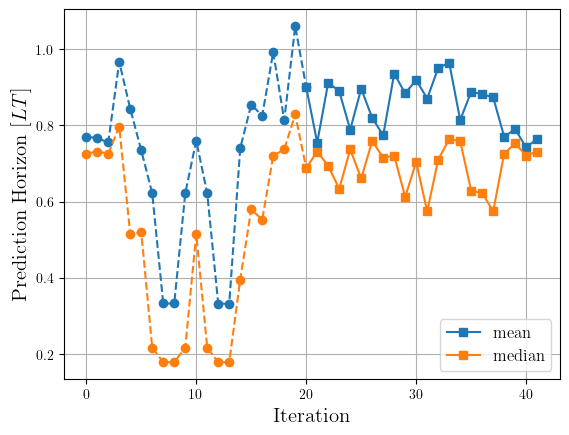

In [90]:
ph_mean_new = np.array(ph_mean_new)
ph_median_new = np.array(ph_median_new)

plt.plot(np.arange(0, n_pregp+1), ph_mean_new[0:n_pregp+1], color='C0', linestyle='--', marker='o', label='__nolegend__')
plt.plot(np.arange(n_pregp, ph_mean_new.shape[0]), ph_mean_new[n_pregp:], color='C0', linestyle='-', marker='s', label='mean')

plt.plot(np.arange(0, n_pregp+1), ph_median_new[0:n_pregp+1], color='C1', linestyle='--', marker='o', label='__nolegend__')
plt.plot(np.arange(n_pregp, ph_median_new.shape[0]), ph_median_new[n_pregp:], color='C1', linestyle='-', marker='s', label='median')

plt.xlabel('Iteration', fontsize=15)
plt.ylabel('Prediction Horizon $[ LT ]$', fontsize=15)
plt.grid(True)

plt.legend(fontsize=12)

plt.show()
# plt.savefig(dir_name_rnn+'/plots/CORRECTED_PH.pdf', dpi=300, bbox_inches='tight')

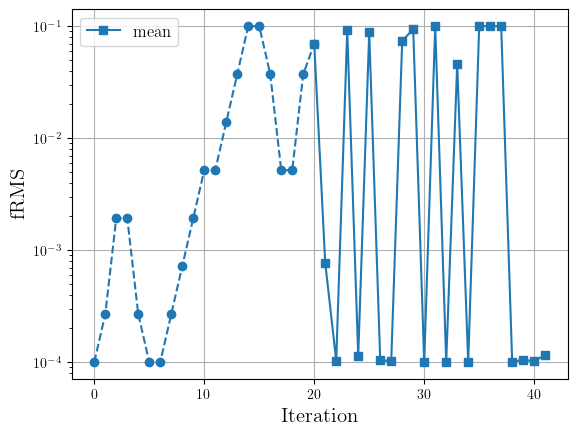

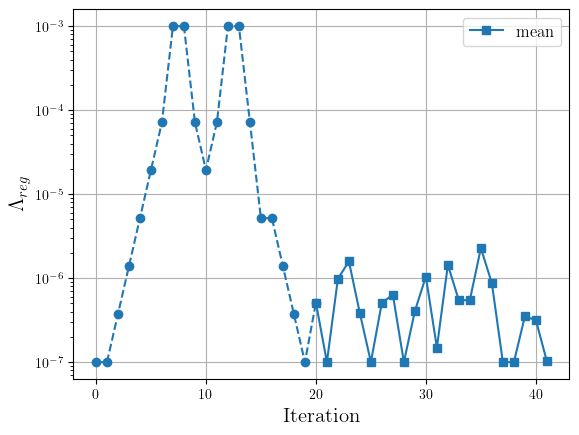

In [94]:
to_plot = [
    [np.array(x0_new)[:, 0], 'fRMS', 'fRMS', 'plt.semilogy'],
    [np.array(x0_new)[:, 1], '$\Lambda_{reg}$', 'lambda_reg', 'plt.semilogy']
]

for i in range(len(to_plot)):
    eval(to_plot[i][3])(np.arange(0, n_pregp+1), to_plot[i][0][0:n_pregp+1], color='C0', linestyle='--', marker='o', label='__nolegend__')
    eval(to_plot[i][3])(np.arange(n_pregp, to_plot[i][0].shape[0]), to_plot[i][0][n_pregp:], color='C0', linestyle='-', marker='s', label='mean')

    plt.xlabel('Iteration', fontsize=15)
    plt.ylabel(to_plot[i][1], fontsize=15)
    plt.grid(True)

    plt.legend(fontsize=12)

    plt.show()
    # plt.savefig(dir_name_rnn+'/plots/CORRECTED_PH.pdf', dpi=300, bbox_inches='tight')

In [ ]:
res

In [ ]:
optim_x = np.array(res.x)
x_iters = np.array(res.x_iters)
func_iters = np.array(res.func_vals)
optim_func = res.fun

optim_idx = np.where(x_iters[:, 0] == optim_x[0])[0]
for i in range(optim_x.shape[0]-1):
    i = i+1
    optim_idx_i = np.where(x_iters[optim_idx, i] == optim_x[i])[0]
    optim_idx = optim_idx[optim_idx_i]
optim_idx = optim_idx[0]

In [ ]:
optim_idx

In [ ]:
a = n_initial_points + len(x0)
# sorted_idx = np.argsort(x_iters[a:, 0])

xplot = np.arange(func_iters.shape[0])

if a > 0:
    plt.plot(
        -func_iters[0:a+1],
        linestyle='--',
        color='C2',
        marker='^',
        label='Initial Points',
    )
    xplot = np.arange(a, func_iters.shape[0])
plt.plot(
    xplot,
    -func_iters[a:],
    linestyle='--',
    marker='^',
    label='GP Minimization',#'__nolegend__',
)
plt.plot([optim_idx], [-func_iters[optim_idx]], 's', label='Optimal Value')

plt.xlabel('Iteration', fontsize=15)
plt.ylabel('Median Prediction Horizon', fontsize=15)
plt.grid(True, which='major', axis='x')
plt.grid(True, which='both', axis='y')
plt.legend(fontsize=12)

plt.savefig(dir_name_rnn_plots+'/median_PH.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
from skopt.plots import plot_convergence
plot_convergence(res)

In [ ]:
optimized_vals_dict = {
    'x_iters':x_iters,
    'func_iters':func_iters,
    'optim_x':optim_x,
    'optim_idx':optim_idx,
    'optim_fun':func_iters[optim_idx]
}

with open(dir_name_rnn+'/optimized_vals.txt', 'w') as f:
    f.write(str(optimized_vals_dict))
    
np.savez(
    dir_name_rnn+'/optimized_vals',
    x_iters=x_iters,
    func_iters=func_iters,
    optim_x=optim_x,
    optim_idx=optim_idx,
    optim_fun=func_iters[optim_idx]
)

In [ ]:
xoptim_names = [
    [r'fRMS', 'fRMS', plt.semilogy],
    [r'$\Lambda_{reg}$', 'lambda_reg', plt.semilogy],
]
if vary_zoneout == True:
    xoptim_names.append(
        [r'$p^{zoneout}$', 'zoneout', plt.plot]
    )

for i in range(len(xoptim_names)):
    a = n_initial_points + len(x0)
    # sorted_idx = np.argsort(x_iters[a:, 0])

    xplot = np.arange(x_iters.shape[0])
    if a > 0:
        xoptim_names[i][2](
            x_iters[:, i][0:a+1],
            linestyle='--',
            color='C2',
            marker='^',
            label='Initial Points',
        )
        xplot = np.arange(a, x_iters.shape[0])
    xoptim_names[i][2](
        xplot,
        x_iters[:, i][a:],
        linestyle='--',
        marker='^',
        label='GP Minimization',#'__nolegend__',
    )
    xoptim_names[i][2]([optim_idx], [x_iters[optim_idx, i]], 's', label='Optimal Value')

    plt.xlabel('Iteration', fontsize=15)
    plt.ylabel(xoptim_names[i][0], fontsize=15)
    plt.grid(True, which='major', axis='x')
    plt.grid(True, which='both', axis='y')
    plt.legend(fontsize=12)

    plt.savefig(dir_name_rnn_plots+'/'+xoptim_names[i][1]+'.pdf', bbox_inches='tight', dpi=300)
    plt.show()

In [ ]:
dir_list = os.listdir(dir_name_rnn+'/tested_rnn')
# dir_list

In [ ]:
ph_mean_lst = []
for dir_name in dir_list:
    with np.load(dir_name_rnn+'/tested_rnn/'+dir_name+'/prediction_horizons-testingdata--combinedAERNN--ZEROoutsteps.npz') as f:
        ph_mean = np.mean(f['prediction_horizon_arr'])
        ph_mean_lst.append(ph_mean)
ph_mean_lst = np.array(ph_mean_lst)

In [ ]:
idx = np.where(ph_mean_lst == ph_mean_lst.max())[0]

In [ ]:
idx, dir_list[idx[0]]

In [ ]:
# convergence plot
convergence_f = np.empty_like(func_iters)
min_val = np.inf
for i in range(func_iters.shape[0]):
    if func_iters[i] < min_val:
        min_val = func_iters[i]
    convergence_f[i] = min_val

In [ ]:
a = n_initial_points + len(x0)
# sorted_idx = np.argsort(x_iters[a:, 0])

xplot = np.arange(x_iters.shape[0])

if a > 0:
    plt.plot(
        -convergence_f[0:a+1],
        linestyle='--',
        color='C2',
        marker='^',
        label='Initial Points',
    )
    xplot = np.arange(a, x_iters.shape[0])
plt.plot(
    xplot,
    -convergence_f[a:],
    linestyle='--',
    marker='^',
    label='GP Minimization',#'__nolegend__',
)
# plt.semilogy([optim_idx], [func_iters[optim_idx, 0]], 's', label='Optimal Value')

plt.xlabel('Iteration', fontsize=15)
plt.ylabel(
#     r"$$\min_{0 \leq j \leq \mathrm{present \ iteration}} \left( \mathrm{Test \ MSE} \right)$$",
#     r"$$\min_{0 \leq j \leq \mathrm{present \atop iteration}} \left( \mathrm{Test \ MSE} \right)$$",
    r"$$\max_{0 \leq j \leq \mathrm{present \atop iteration}} \left( \mathrm{Median \ PH} \right)$$",
    fontsize=15,
)
plt.title('Convergence Plot', fontsize=18)
plt.grid(True, which='major', axis='x')
plt.grid(True, which='both', axis='y')
plt.legend(fontsize=12)

plt.savefig(dir_name_rnn_plots+'/convergence_plot.pdf', bbox_inches='tight', dpi=300)
plt.show()

### Prediction horizon computation